In [2]:
import numpy as np
import pandas as pd
import struct
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_style('darkgrid')
import sys
import os
import seaborn
from  matplotlib import pyplot

In [3]:
import io

# functions for reading files

def read_wrappings(file_path):
    if(os.path.isfile(file_path)):
        with open(file_path, 'r') as f:
            lines = f.readlines()

            # remove spaces
            for i in range(0, len(lines)):
                lines[i] = lines[i].lstrip()
                lines[i] = lines[i][0 : lines[i].find(' ')] + ',' + lines[i][lines[i].find(' ') : len(lines[i])]
                lines[i] = lines[i].replace(' ', '')
                
            lines.insert(0, 'winding_number,cluster_number')

            df = pd.read_csv(io.StringIO('\n'.join(lines)), index_col=None, dtype={'cluster_number': 'int64'})
            return df
        
def read_density_lower(file_path):
    cluster_size = list(range(4, 203, 2))
    df = []
    if(os.path.isfile(file_path)):
        with open(file_path, 'r') as f:
            lines = f.readlines()
            
            for i in range(3):
                
                d = {'cluster size': cluster_size, 'number': list(map(int, lines[i].split()[:100]))}
                df.append( pd.DataFrame(data=d) )
            
    df = pd.concat(df)
    groupby = df.groupby('cluster size').agg([('number', np.mean)]).reset_index()
    return df

def read_density_upper(file_path):
    df = []
    if(os.path.isfile(file_path)):
        with open(file_path, 'r') as f:
            lines = f.readlines()
            
            for color in range(3):
                
                arr = np.array(list(map(int, lines[color].split()[100:])))
                arr = arr[arr != 0]
                arr_unique, counts = np.unique(arr, return_counts=True)
                
                d = {'color': color, 'cluster size': arr_unique, 'number': counts}
                df.append( pd.DataFrame(data=d) )
            
    df = pd.concat(df)
    return df
        
def read_data(start, end, paths, data_name, func):
    data = []
    for path in paths:
        for i in range(start, end + 1):
            data_path = f'{path[0]}/{data_name}_{i:04}'
            if(os.path.isfile(data_path)):
                # data.append(func(data_path))
                data.append(pd.read_csv(data_path, dtype={'cluster_number': 'int64'}))
                data[-1]['conf'] = i
                data[-1]['time size'] = path[1]
    
    return pd.concat(data)

def read_data_old_and_new(start, end, paths_new, paths_old, data_name, func_old):
    data1 = []
    data = []
    for path in paths_old:
        for i in range(start, end + 1):
            data_path = f'{path[0]}/wrappings_{i:04}'
            if(os.path.isfile(data_path)):
                data.append(func_old(data_path))
                data[-1]['conf'] = i
                data[-1]['time size'] = path[1]
                data[-1]['version'] = 'old'
    
    data1.append(pd.concat(data))

    data = []

    for path in paths_new:
        for i in range(start, end + 1):
            data_path = f'{path[0]}/{data_name}_{i:04}'
            if(os.path.isfile(data_path)):
                data.append(pd.read_csv(data_path, dtype={'cluster_number': 'int64'}))
                data[-1]['conf'] = i
                data[-1]['time size'] = path[1]
                data[-1]['version'] = 'new'

    data2 = pd.concat(data)

    data2 = data2[data2['direction'] == 'time']
    data2 = data2.drop(columns=['direction'])
    data2 = data2.set_index(['time size', 'conf', 'color', 'winding_number', 'version']).unstack('winding_number', fill_value=0).stack().reset_index()
    data1.append(data2)

    return pd.concat(data1)

def read_data_copies(start, end, paths, data_name, func):
    data = []
    for path in paths:
        for i in range(start, end + 1):
            last_copy = f'{path[0]}/{data_name}_{i:04}_1'
            if(os.path.isfile(last_copy)):
                for j in range(1, path[2]):
                    data_path = f'{path[0]}/{data_name}_{i:04}_{j}'
                    if(os.path.isfile(data_path)):
                        data.append(func(data_path))
                        data[-1]['num'] = i
                        data[-1]['steps'] = path[1]
                        data[-1]['copy'] = j
                        last_copy = f'{path[0]}/{data_name}_{i:04}_{j}'
                    else:
                        data.append(func(last_copy))
                        data[-1]['num'] = i
                        data[-1]['steps'] = path[1]
                        data[-1]['copy'] = j
                    
    for path in paths:
        for i in range(start, end + 1):
            data_path = f'{path[0]}/{data_name}_{i:04}'
            if(os.path.isfile(data_path)):
                data.append(func(data_path))
                data[-1]['num'] = i
                data[-1]['steps'] = path[1]
                data[-1]['copy'] = path[2]
    
    return pd.concat(data)

In [4]:
# functions for wrappings processing

# save image
def save_image_time_wrappings(image_path, image_name, fg):
    try:
        os.makedirs(image_path)
    except:
        pass
    
    output_path = f'{image_path}/{image_name}'
    fg.savefig(output_path, dpi=400)

# make plots
def make_plot_time_wrappings(data):
    wrapping_number = data['winding_number'].iloc[0]
    fg = seaborn.FacetGrid(data=data, height=5, aspect=1.61)
    fg.fig.suptitle(f'winding_number = {wrapping_number}')
    fg.map(plt.errorbar, 'time size', 'cluster_number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    
    # save_image_time_wrappings('../../images/common', f'time-wrappings_wrapping_number={wrapping_number}', fg)

def make_plot_time_wrappings_old_and_new(data, image_path):
    time_size = data['time size'].iloc[0]
    fg = seaborn.FacetGrid(data=data, hue = 'version', height=5, aspect=1.61)
    plt.yscale('log')
    fg.fig.suptitle(f'Nt{time_size}')
    fg.map(plt.errorbar, 'winding_number', 'cluster_number', 'std', marker="o", fmt='', linestyle = '').add_legend()

    save_image_time_wrappings(image_path, f'Nt{time_size}', fg)
    
def data_process_wrappings(data):
    return data.groupby(['winding_number', 'time size', 'conf'])['cluster_number']\
        .agg([('cluster_number', np.mean)]).reset_index()\
        .groupby(['winding_number', 'time size'])['cluster_number']\
        .agg([('cluster_number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index()

def data_process_wrappings_old_and_new(data):
    return data.groupby(['winding_number', 'time size', 'conf', 'version'])['cluster_number']\
        .agg([('cluster_number', np.mean)]).reset_index()\
        .groupby(['winding_number', 'time size', 'version'])['cluster_number']\
        .agg([('cluster_number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index()

def make_plot_time_wrappings_copies(data):
    wrapping_number = data['wrapping number'].iloc[0]
    fg = seaborn.FacetGrid(data=data, hue='steps', height=5, aspect=1.61)
    fg.fig.suptitle(f'wrapping number = {wrapping_number}')
    fg.map(plt.errorbar, 'copy', 'monopole number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    
    save_image_time_wrappings('../../images/common', f'number-wrappings_copies_wrapping_number={wrapping_number}', fg)
    
def data_process_wrappings_copies(data):
    return data.groupby(['wrapping number', 'steps', 'num', 'copy'])['monopole number']\
        .agg([('monopole number', np.mean)]).reset_index()\
        .groupby(['wrapping number', 'steps', 'copy'])['monopole number']\
        .agg([('monopole number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index()

def make_plot_number_wrappings_copies(data):
    steps = data['steps'].iloc[0]
    fg = seaborn.FacetGrid(data=data, hue = 'copy', height=5, aspect=1.61)
    plt.yscale('log')
    fg.map(plt.errorbar, 'wrapping number', 'monopole number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    
    # save_image_time_wrappings('../../images/common', f'number-wrappings_copies_steps={steps}', fg)

# top level functions

# fill with zeros missing values
def fill_windings(data):
    return data.set_index(['conf', 'color', 'winding_number']).unstack('winding_number', fill_value=0).stack()

def wrappings_time_dependence(start, end, paths):
    data = read_data(start, end, paths, 'windings', read_wrappings)
    # data = read_data(start, end, paths, 'wrappings', read_wrappings)

    data = data[data['direction'] == 'time']
    data = data.drop(columns=['direction'])
    data = data.set_index(['time size', 'conf', 'color', 'winding_number']).unstack('winding_number', fill_value=0).stack()
    # data = data.groupby(['time size'])[['color', 'cluster_number', 'winding_number', 'conf']].apply(fill_windings).reset_index()

    data = data_process_wrappings(data)

    data.groupby(['winding_number']).apply(make_plot_time_wrappings)
    
    # data.to_csv('../../data/wrappings_common', sep = ' ', index=False)
    
def wrappings_number_dependence(start, end, paths):
    data = read_data(start, end, paths, 'windings', read_wrappings)

    data = data[data['direction'] == 'time']
    data = data.drop(columns=['direction'])
    data = data.set_index(['time size', 'conf', 'color', 'winding_number']).unstack('winding_number', fill_value=0).stack().reset_index()

    data = data_process_wrappings(data)
    
    fg = seaborn.FacetGrid(data=data, hue = 'time size', height=5, aspect=1.61)
    plt.yscale('log')
    fg.map(plt.errorbar, 'winding_number', 'cluster_number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    
    # save_image_time_wrappings('../../images/common', f'number-wrappings', fg)
    
    # data.to_csv('../../data/wrappings_common', sep = ' ', index=False)

def wrappings_number_dependence_old_and_new(start, end, paths_new, paths_old, image_path):
    data = read_data_old_and_new(start, end, paths_new, paths_old, 'windings', read_wrappings)

    data = data_process_wrappings_old_and_new(data)

    data.groupby(['time size']).apply(make_plot_time_wrappings_old_and_new, image_path)
    
def wrappings_time_copies(start, end, paths):
    
    data = read_data_copies(start, end, paths, "wrappings", read_wrappings)
    
    data = data_process_wrappings_copies(data)
    
    data.groupby(['wrapping number']).apply(make_plot_time_wrappings_copies)
        
    # data.to_csv('../../data/wrappings_copies_common', sep = ' ', index=False)
    
def wrappings_number_copies(start, end, paths):
    
    data = read_data_copies(start, end, paths, "wrappings", read_wrappings)
    
    data = data_process_wrappings_copies(data)
    
    data.groupby(['steps']).apply(make_plot_number_wrappings_copies)
        
    # data.to_csv('../../data/wrappings_copies_common', sep = ' ', index=False)

def exponent(x, a, mu):
    return a * np.exp(-mu * x) * np.power(x, -5/2)

def exponent1(x, a, mu, b):
    return a * np.exp(-mu * x) * np.power(x, -b)

def inverse_polinomial(x, a):
    return a * np.power(x, -5/2)

def inverse_polinomial1(x, a, b):
    return a * np.power(x, -b)

def fit_data(data, func):
    popt, pcov = curve_fit(func, data['winding_number'].to_numpy(), data['cluster_number'].to_numpy())
    return pd.Series({'params': popt})

def fit_data_polinomial(data):
    popt, pcov = curve_fit(inverse_polinomial, data['winding_number'].to_numpy(), data['cluster_number'].to_numpy())
    return pd.Series({'a': popt[0]})

def plot_fit_func_exponent(data, min, max):
    x = np.arange(min, max, 0.001)
    y = exponent(x, data['params'].iloc[0][0], data['params'].iloc[0][1])
    return pd.DataFrame({'winding_number': x, 'cluster_number': y, 'std': 0})

def plot_fit_func_exponent1(data, min, max):
    x = np.arange(min, max, 0.001)
    y = exponent1(x, data['params'].iloc[0][0], data['params'].iloc[0][1], data['params'].iloc[0][2])
    return pd.DataFrame({'winding_number': x, 'cluster_number': y, 'std': 0})

def plot_fit_func_polinomial(data, min, max):
    x = np.arange(min, max, 0.001)
    y = inverse_polinomial(x, data['params'].iloc[0][0])
    return pd.DataFrame({'winding_number': x, 'cluster_number': y, 'std': 0})

def plot_fit_func_polinomial1(data, min, max):
    x = np.arange(min, max, 0.001)
    y = inverse_polinomial1(x, data['params'].iloc[0][0], data['params'].iloc[0][1])
    return pd.DataFrame({'winding_number': x, 'cluster_number': y, 'std': 0})

def plot_test(data):
    plt.plot(data['winding_number'], data['cluster_number'])

def fit_wrappings(start, end, paths, ranges, func, plotting_func, name):
    data = read_data(start, end, paths, 'windings', read_wrappings)

    data = data[data['direction'] == 'time']
    data = data.drop(columns=['direction'])
    data = data.set_index(['time size', 'conf', 'color', 'winding_number']).unstack('winding_number', fill_value=0).stack()
    
    data = data_process_wrappings(data)

    # print(data)
    # data.to_csv('../../data/wrappings_common', sep = ',', index=False)

    for d in ranges:
        data = data[(data['winding_number'] <= ranges[d][1]) | np.logical_not((data['time size'] == d))]
        data = data[(data['winding_number'] >= ranges[d][0]) | np.logical_not((data['time size'] == d))]

    df = data.groupby(['time size']).apply(fit_data, func).reset_index()
    # print(df)

    # df1 = df.groupby(['time size']).apply(plot_fit_func_polinomial, data['winding_number'].min(), data['winding_number'].max())
    df1 = df.groupby(['time size']).apply(plotting_func, data['winding_number'].min(), data['winding_number'].max())

    df1.index = df1.index.get_level_values('time size')
    df1 = df1.reset_index()

    fg = seaborn.FacetGrid(data=data, hue = 'time size', height=5, aspect=1.61)
    plt.yscale('log')
    fg.map(plt.errorbar, 'winding_number', 'cluster_number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    
    df1.groupby(['time size']).apply(plot_test)

    # save_image_time_wrappings('../../images/common/fit', f'{name}', fg)
    # plt.plot(df1['winding_number'], df1['monopole number'])
    return df

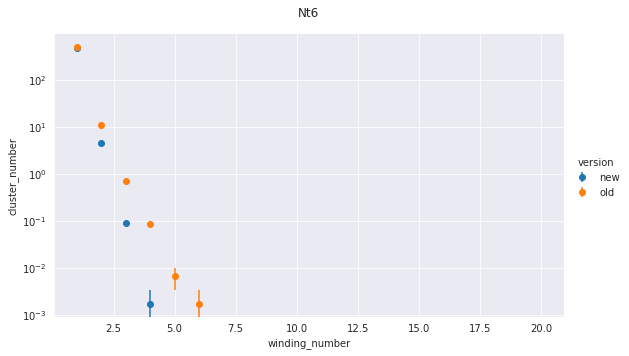

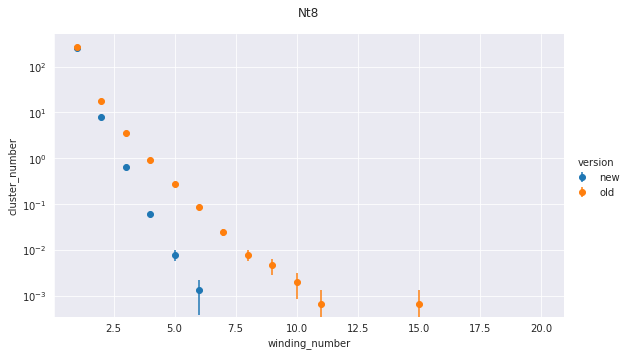

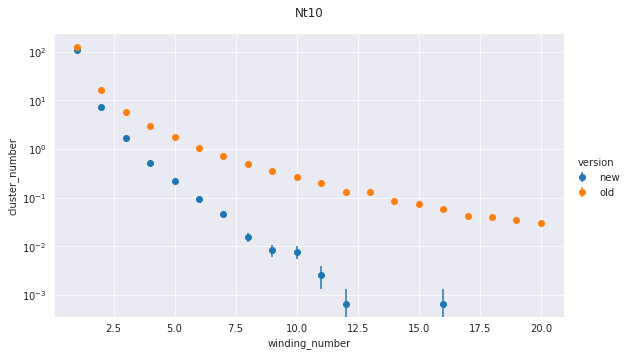

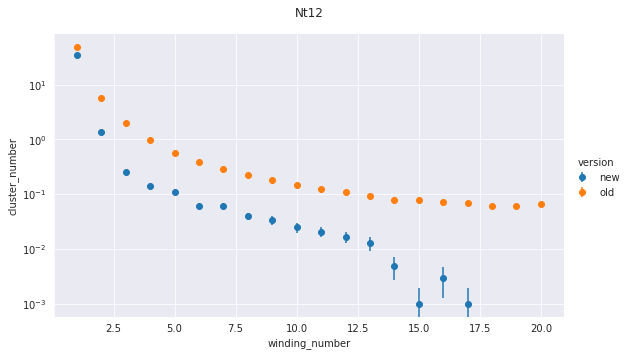

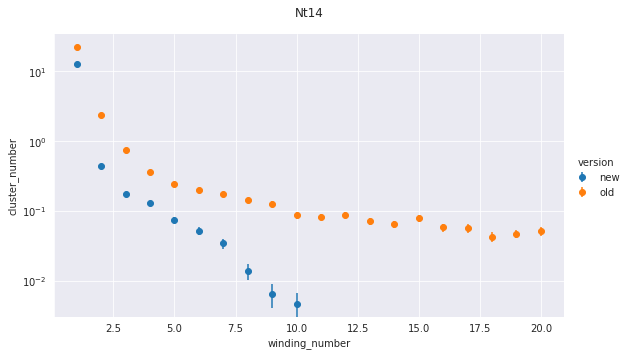

In [48]:
paths_new = [('../data/monopoles_su3/QCD/140MeV/nt6/DP_steps_330/copies=1/windings', 6), ('../data/monopoles_su3/QCD/140MeV/nt8/DP_steps_330/copies=1/windings', 8), \
        ('../data/monopoles_su3/QCD/140MeV/nt10/DP_steps_330/copies=1/windings', 10), ('../data/monopoles_su3/QCD/140MeV/nt12/DP_steps_330/copies=1/windings', 12), \
        ('../data/monopoles_su3/QCD/140MeV/nt14/DP_steps_330/copies=1/windings', 14)]

paths_old = [('../data/monopoles_su3/nt6/steps_330/copies=1', 6), ('../data/monopoles_su3/nt8/steps_330/copies=1', 8), \
        ('../data/monopoles_su3/nt10/steps_330/copies=1', 10), ('../data/monopoles_su3/nt12/steps_330/copies=1', 12), \
        ('../data/monopoles_su3/nt14/steps_330/copies=1', 14)]

image_path = '../images/monopoles_su3/QCD/140MeV/windings_old_and_new'

wrappings_number_dependence_old_and_new(501, 1200, paths_new, paths_old, image_path)

In [5]:
# paths = [('../../data/nt6/steps_330/copies=1', 6), ('../../data/nt8/steps_330/copies=1', 8), \
#         ('../../data/nt10/steps_330/copies=1', 10), ('../../data/nt12/steps_330/copies=1', 12), \
#         ('../../data/nt14/steps_330/copies=1', 14)]

ranges = {4: (2, 7), 6: (2, 7), 8: (2, 13), 10: (4, 20), 12: (3, 20), 14: (3, 20)}

df = []

paths = [('../data/monopoles_su3/QCD/140MeV/nt4/DP_steps_2000/copies=1/windings', 4), ('../data/monopoles_su3/QCD/140MeV/nt6/DP_steps_330/copies=1/windings', 6), ('../data/monopoles_su3/QCD/140MeV/nt8/DP_steps_330/copies=1/windings', 8)]

df.append(fit_wrappings(501, 1200, paths, ranges, exponent, plot_fit_func_exponent, 'fixed_4-8'))

paths = [('../data/monopoles_su3/QCD/140MeV/nt10/DP_steps_330/copies=1/windings', 10), ('../data/monopoles_su3/QCD/140MeV/nt12/DP_steps_330/copies=1/windings', 12), \
        ('../data/monopoles_su3/QCD/140MeV/nt14/DP_steps_330/copies=1/windings', 14)]

df.append(fit_wrappings(501, 1200, paths, ranges, exponent, plot_fit_func_exponent, 'fixed_10-14'))

df = pd.concat(df)
# print(df)
params = df['params'].to_numpy()
arr_mu = []
for i in range(len(params)):
    arr_mu.append(params[i][1])
# print('arr_mu ', arr_mu)
df['mu'] = arr_mu
# print(df)
# print(df['params'])
# print(data)

# df['aT'] =  1 / df['time size']
df['aT'] =  df['time size']

fg = seaborn.FacetGrid(data=df, height=5, aspect=1.61)
fg.map(plt.errorbar, 'aT', 'mu', marker="o", fmt='', linestyle = '').add_legend()

# save_image_time_wrappings('../../images/common/fit', f'mu_fixed', fg)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

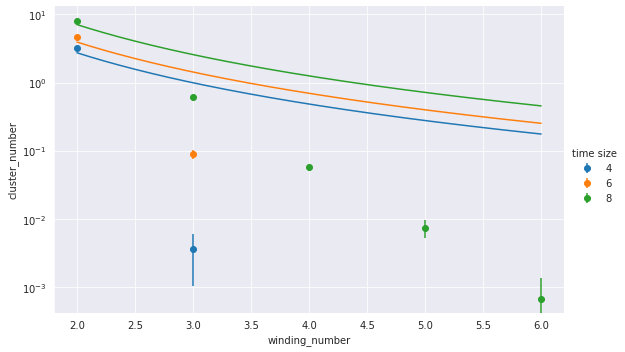

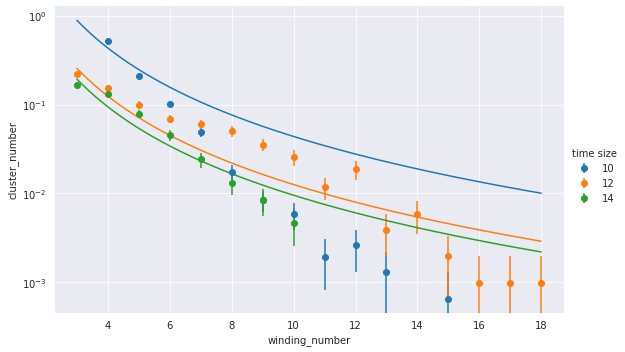

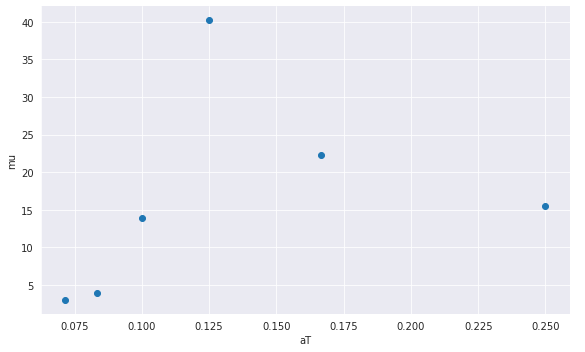

In [13]:
ranges = {4: (2, 6), 6: (2, 7), 8: (2, 6), 10: (4, 20), 12: (3, 20), 14: (3, 20)}

df = []

paths = [('../data/monopoles_su3/QCD/140MeV/nt4/DP_steps_2000/copies=1/windings', 4), ('../data/monopoles_su3/QCD/140MeV/nt6/DP_steps_330/copies=1/windings', 6), \
        ('../data/monopoles_su3/QCD/140MeV/nt8/DP_steps_330/copies=1/windings', 8)]

df.append(fit_wrappings(501, 1200, paths, ranges, inverse_polinomial, plot_fit_func_polinomial, 'fixed_4-8'))

paths = [('../data/monopoles_su3/QCD/140MeV/nt10/DP_steps_330/copies=1/windings', 10), ('../data/monopoles_su3/QCD/140MeV/nt12/DP_steps_330/copies=1/windings', 12), \
        ('../data/monopoles_su3/QCD/140MeV/nt14/DP_steps_330/copies=1/windings', 14)]

df.append(fit_wrappings(501, 1200, paths, ranges, inverse_polinomial, plot_fit_func_polinomial, 'fixed_10-14'))

df = pd.concat(df)
# print(df)
params = df['params'].to_numpy()
arr_mu = []
for i in range(len(params)):
    arr_mu.append(params[i][0])
# print('arr_mu ', arr_mu)
df['mu'] = arr_mu
# print(df)
# print(df['params'])
# print(data)

df['aT'] =  1 / df['time size']

fg = seaborn.FacetGrid(data=df, height=5, aspect=1.61)
fg.map(plt.errorbar, 'aT', 'mu', marker="o", fmt='', linestyle = '').add_legend()

In [7]:
ranges = {4: (2, 7), 6: (2, 7), 8: (2, 13), 10: (4, 20), 12: (3, 20), 14: (3, 20)}

df = []

paths = [('../../data/nt6/steps_330/copies=1', 6), ('../../data/nt8/steps_330/copies=1', 8)]

df.append(fit_wrappings(501, 1200, paths, ranges, exponent1, plot_fit_func_exponent1, 'unfixed_6-8'))

paths = [('../../data/nt10/steps_330/copies=1', 10), ('../../data/nt12/steps_330/copies=1', 12), \
        ('../../data/nt14/steps_330/copies=1', 14)]

df.append(fit_wrappings(501, 1200, paths, ranges, exponent1, plot_fit_func_exponent1, 'unfixed_10-14'))

df = pd.concat(df)
# print(df)
params = df['params'].to_numpy()
arr_mu = []
arr_b = []
for i in range(len(params)):
    arr_mu.append(params[i][1])
    arr_b.append(params[i][2])
df['mu'] = arr_mu
df['b'] = arr_b

df['aT'] =  1 / df['time size']

fg = seaborn.FacetGrid(data=df, height=5, aspect=1.61)
fg.map(plt.errorbar, 'aT', 'mu', marker="o", fmt='', linestyle = '').add_legend()

save_image_time_wrappings('../../images/common/fit', f'mu_unfixed', fg)

fg = seaborn.FacetGrid(data=df, height=5, aspect=1.61)
fg.map(plt.errorbar, 'aT', 'b', marker="o", fmt='', linestyle = '').add_legend()

save_image_time_wrappings('../../images/common/fit', f'b_unfixed', fg)

ValueError: No objects to concatenate

In [97]:
df2 = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]),
                   columns=['a', 'b', 'c'])

print(df2)

def test_func(data):
    return pd.Series({'e': 1, 'd': 3})

df2 = df2.groupby(['a'])['b'].apply(test_func).unstack().reset_index()
print(df2)

   a  b  c
0  1  2  3
1  4  5  6
2  7  8  9
   a  e  d
0  1  1  3
1  4  1  3
2  7  1  3


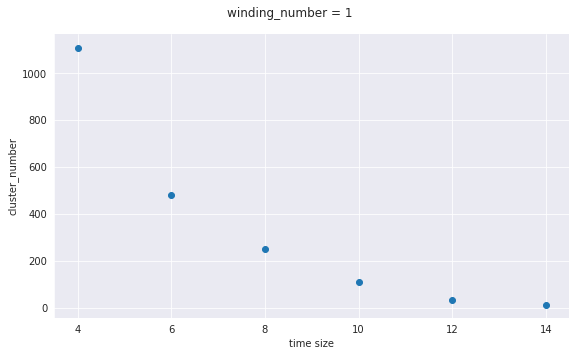

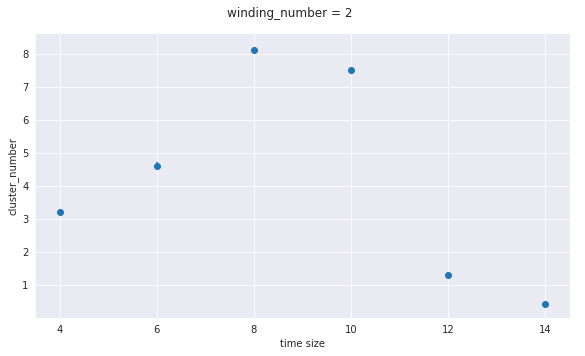

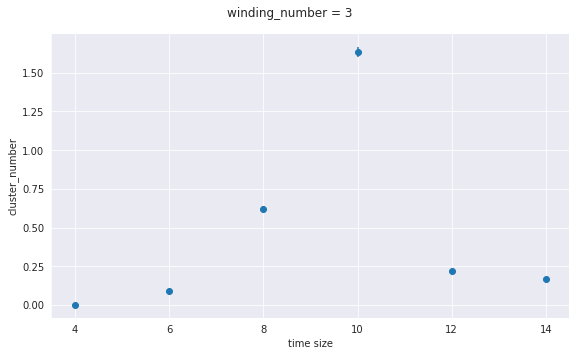

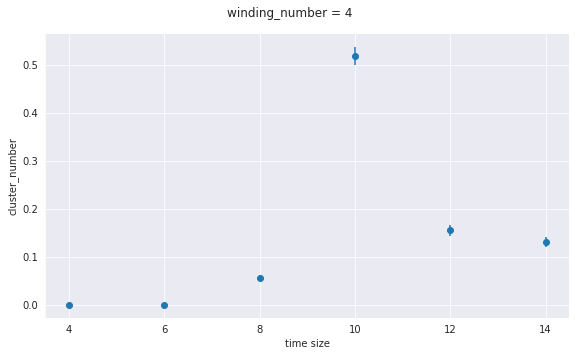

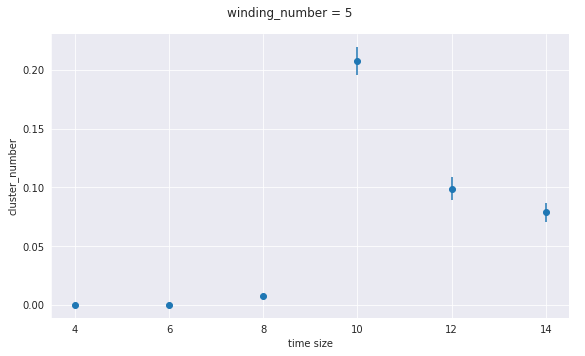

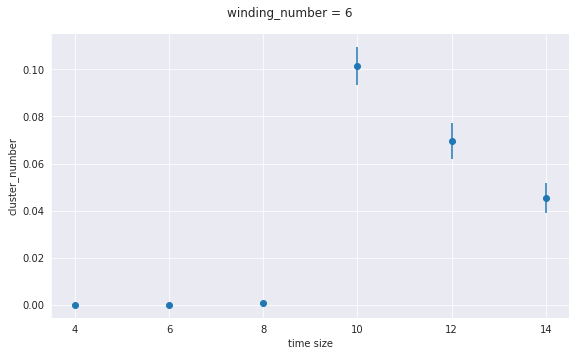

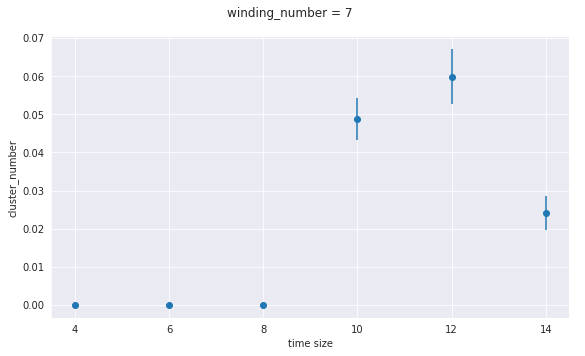

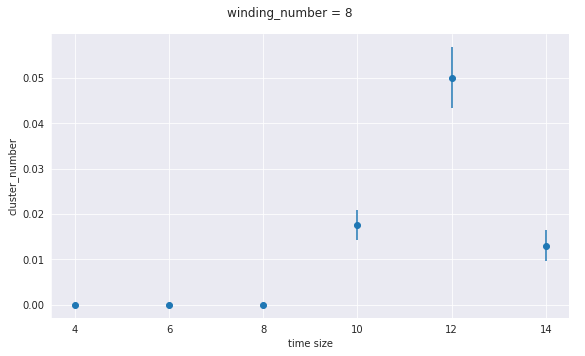

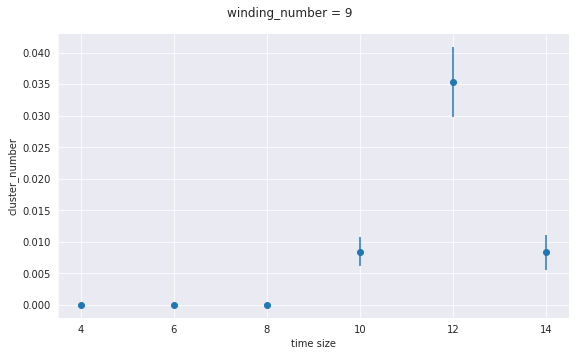

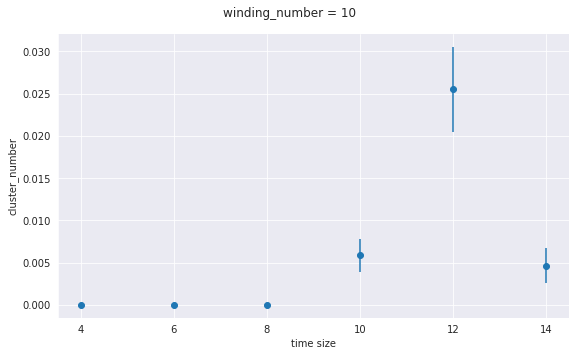

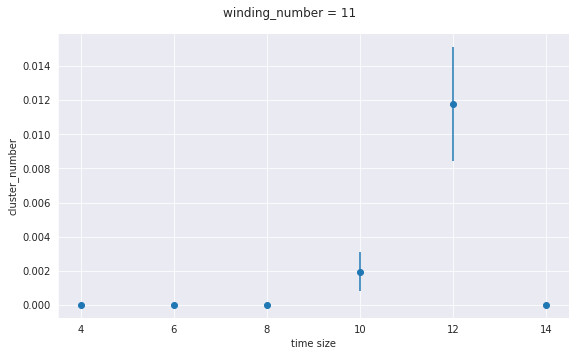

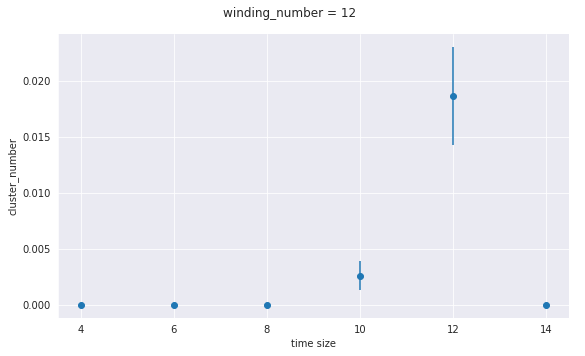

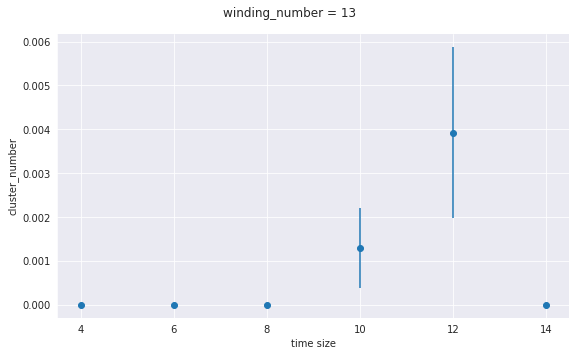

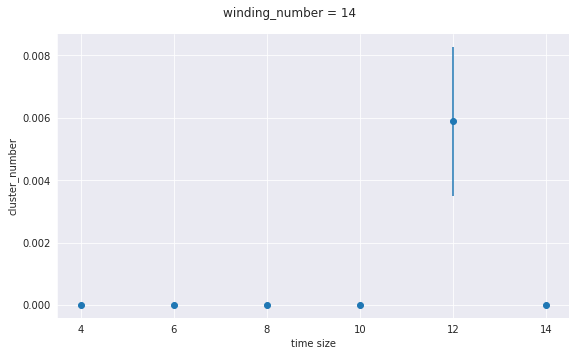

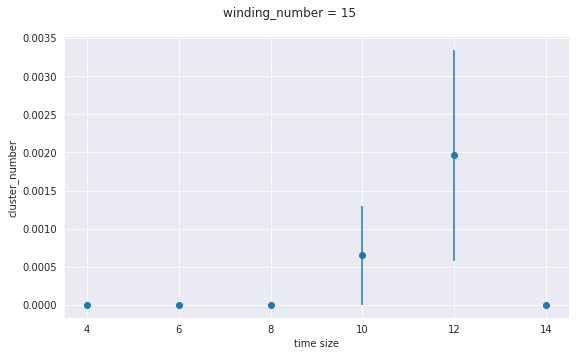

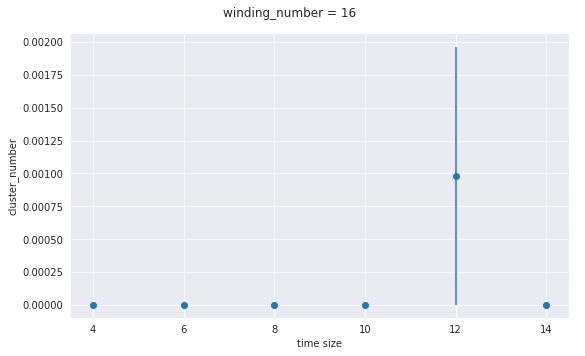

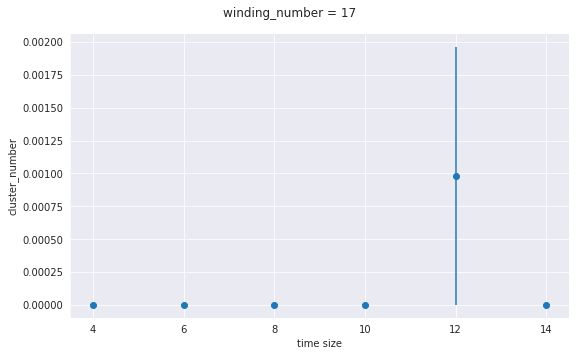

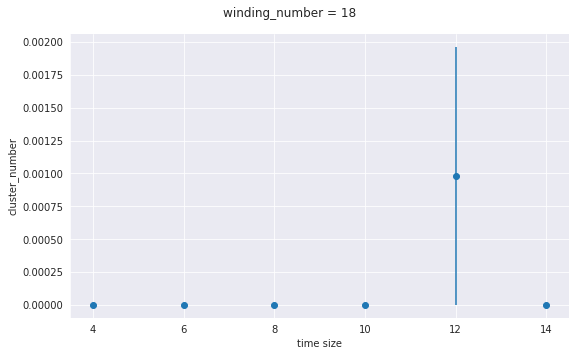

In [8]:
paths = [('../data/monopoles_su3/QCD/140MeV/nt4/DP_steps_2000/copies=1/windings', 4), ('../data/monopoles_su3/QCD/140MeV/nt6/DP_steps_330/copies=1/windings', 6), ('../data/monopoles_su3/QCD/140MeV/nt8/DP_steps_330/copies=1/windings', 8), \
        ('../data/monopoles_su3/QCD/140MeV/nt10/DP_steps_330/copies=1/windings', 10), ('../data/monopoles_su3/QCD/140MeV/nt12/DP_steps_330/copies=1/windings', 12), \
        ('../data/monopoles_su3/QCD/140MeV/nt14/DP_steps_330/copies=1/windings', 14)]

wrappings_time_dependence(501, 1200, paths)

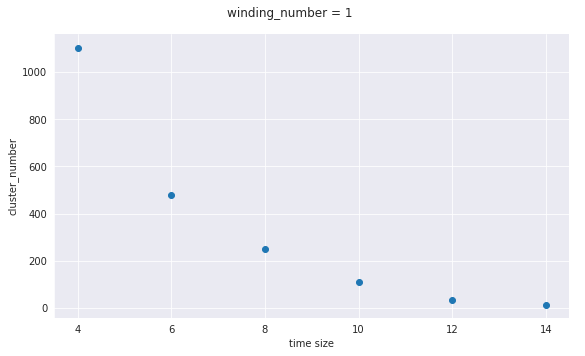

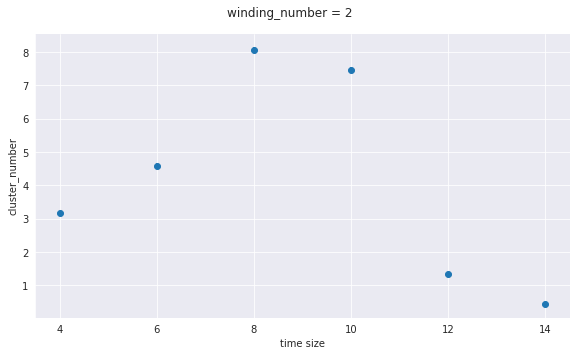

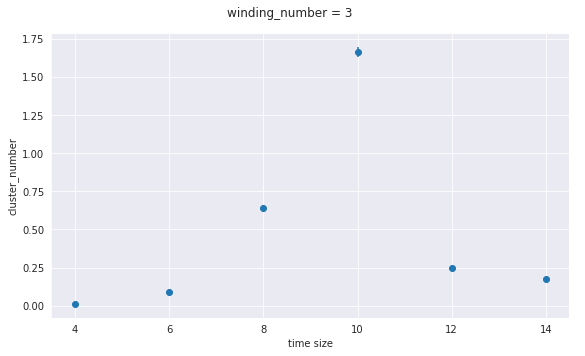

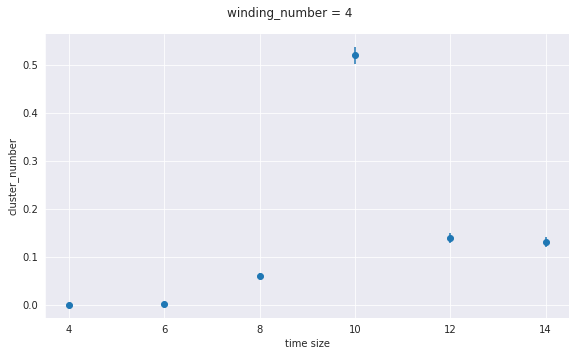

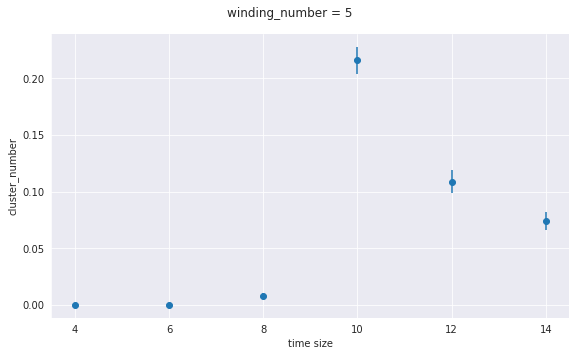

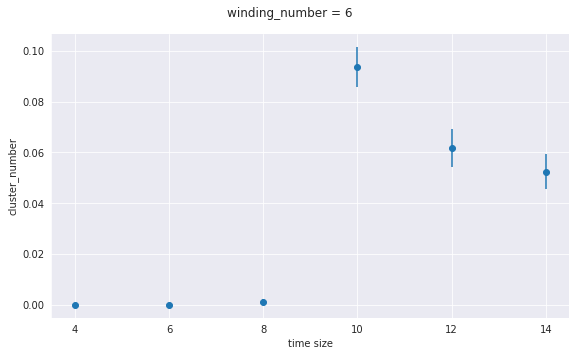

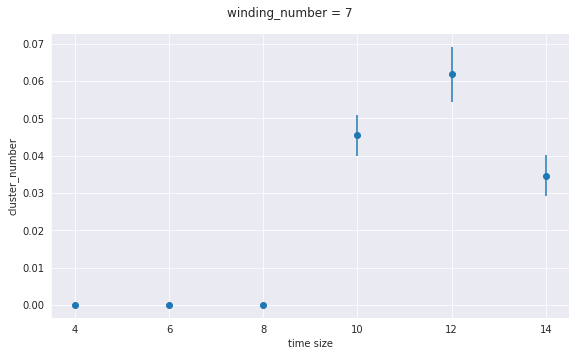

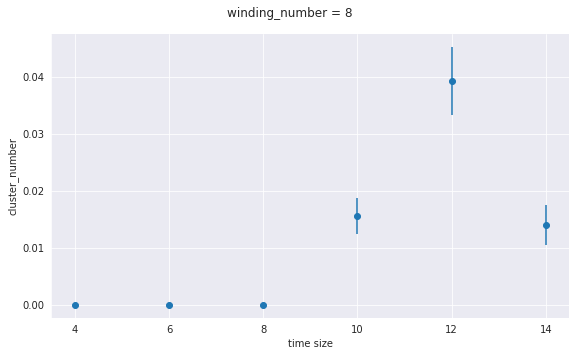

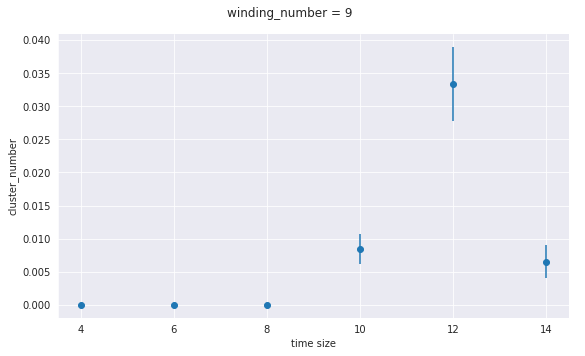

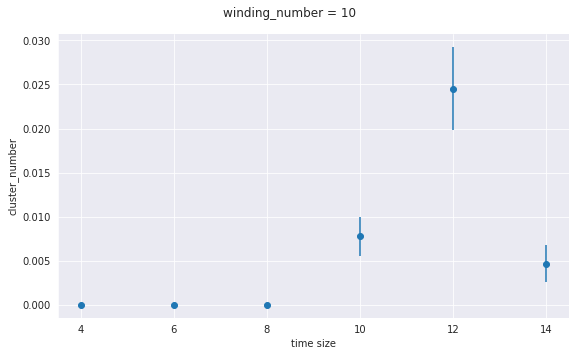

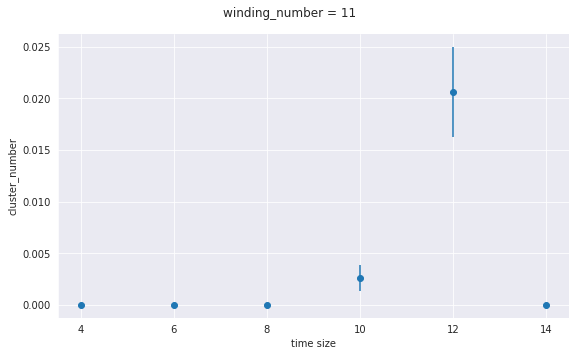

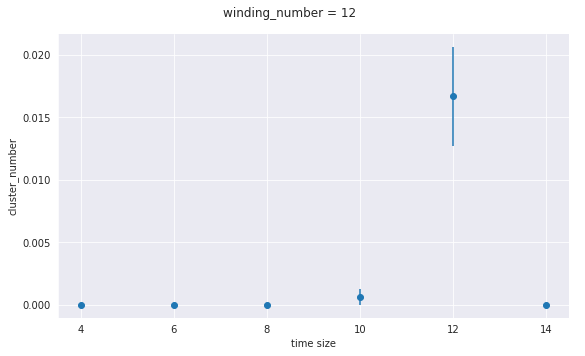

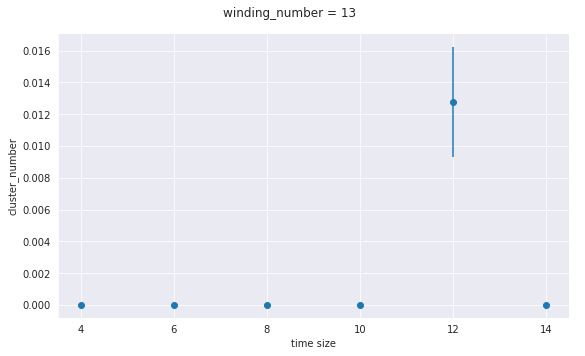

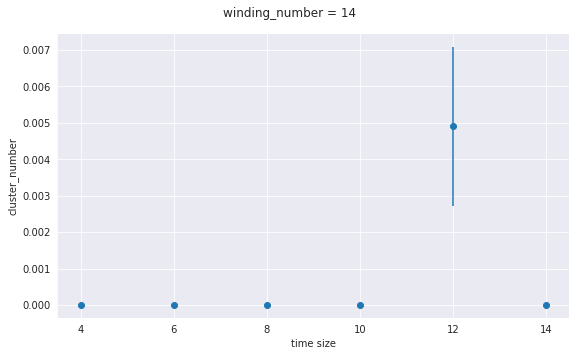

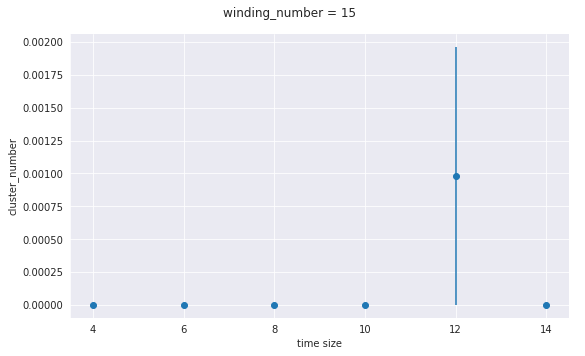

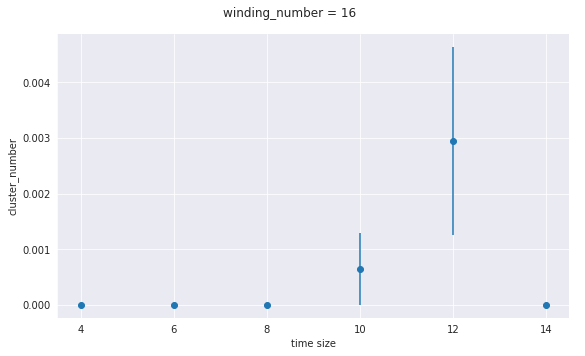

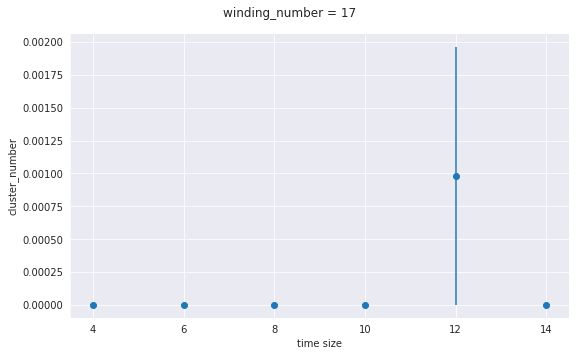

In [7]:
paths = [('../data/monopoles_su3/QCD/140MeV/nt4/DP_steps_2000/copies=1/windings', 4), ('../data/monopoles_su3/QCD/140MeV/nt6/DP_steps_330/copies=1/windings', 6), ('../data/monopoles_su3/QCD/140MeV/nt8/DP_steps_330/copies=1/windings', 8), \
        ('../data/monopoles_su3/QCD/140MeV/nt10/DP_steps_330/copies=1/windings', 10), ('../data/monopoles_su3/QCD/140MeV/nt12/DP_steps_330/copies=1/windings', 12), \
        ('../data/monopoles_su3/QCD/140MeV/nt14/DP_steps_330/copies=1/windings', 14)]

wrappings_time_dependence(501, 1200, paths)

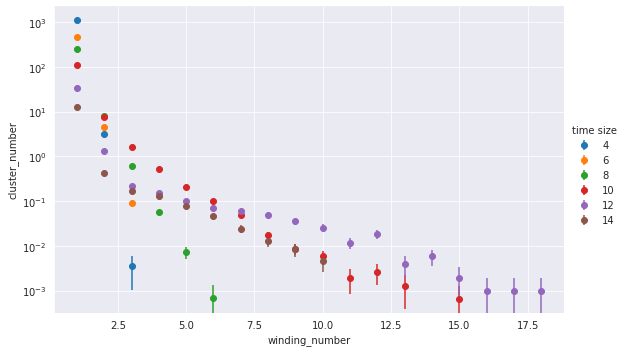

In [9]:
paths = [('../data/monopoles_su3/QCD/140MeV/nt4/DP_steps_2000/copies=1/windings', 4), ('../data/monopoles_su3/QCD/140MeV/nt6/DP_steps_330/copies=1/windings', 6), ('../data/monopoles_su3/QCD/140MeV/nt8/DP_steps_330/copies=1/windings', 8), \
        ('../data/monopoles_su3/QCD/140MeV/nt10/DP_steps_330/copies=1/windings', 10), ('../data/monopoles_su3/QCD/140MeV/nt12/DP_steps_330/copies=1/windings', 12), \
        ('../data/monopoles_su3/QCD/140MeV/nt14/DP_steps_330/copies=1/windings', 14)]

wrappings_number_dependence(501, 1200, paths)

    winding_number  cluster_number  conf  time size
0                1             500   501          6
1                2               9   501          6
2                3               0   501          6
3                4               0   501          6
4                5               0   501          6
..             ...             ...   ...        ...
55              16               0   828         14
56              17               0   828         14
57              18               0   828         14
58              19               0   828         14
59              20               0   828         14

[110100 rows x 4 columns]


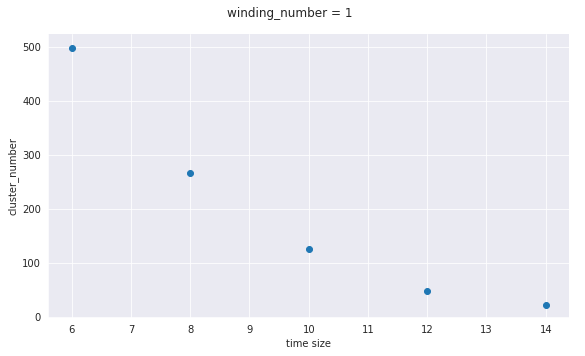

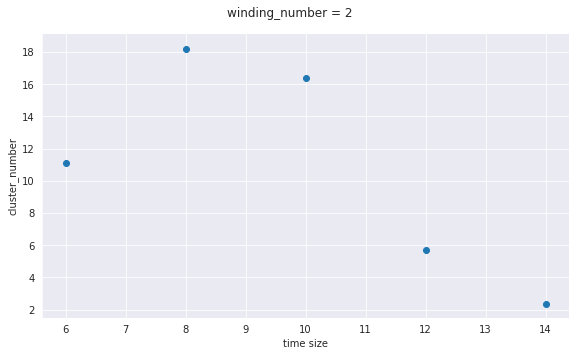

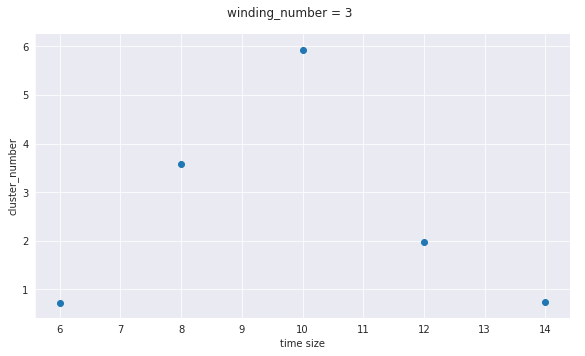

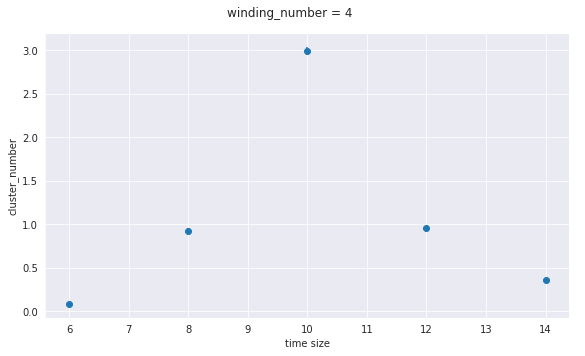

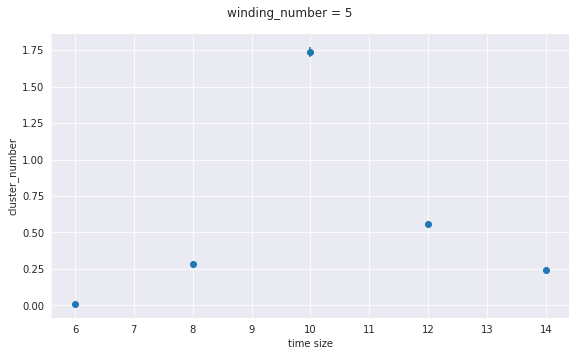

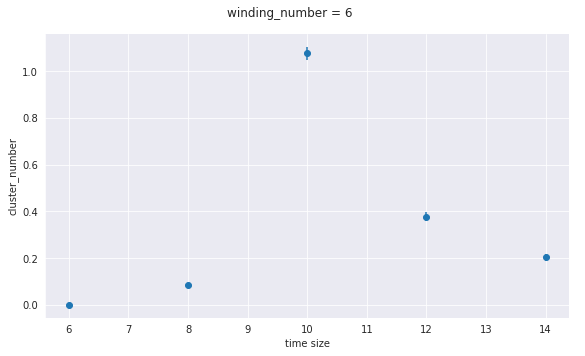

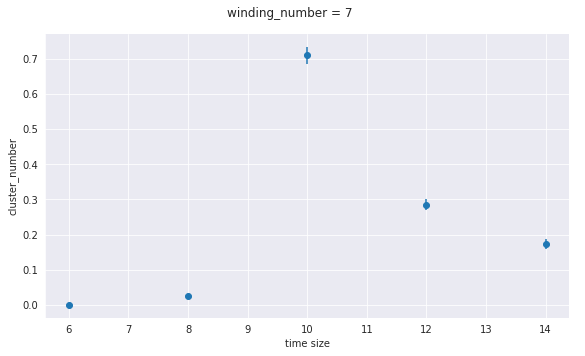

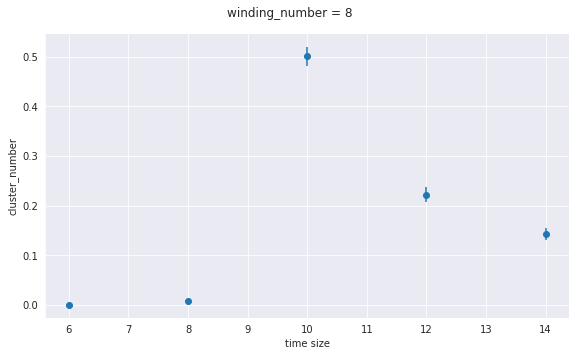

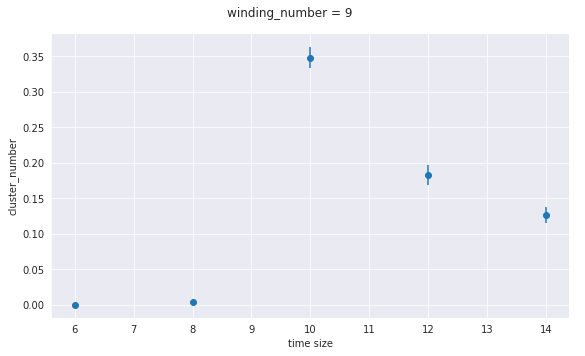

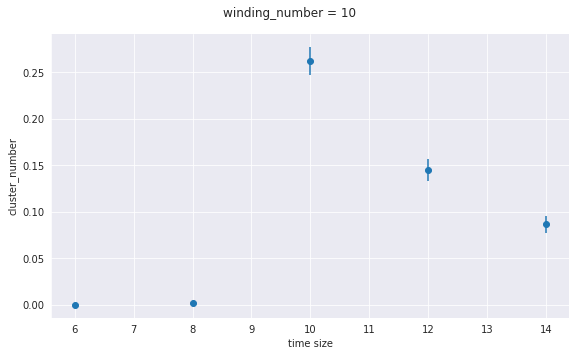

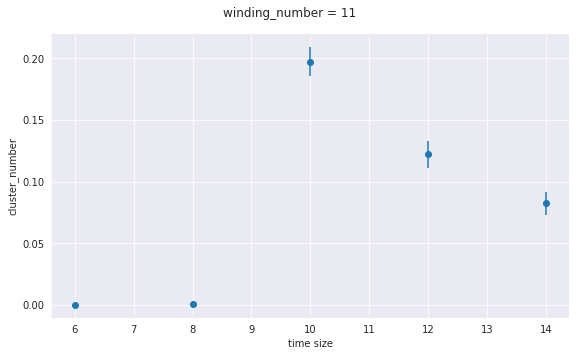

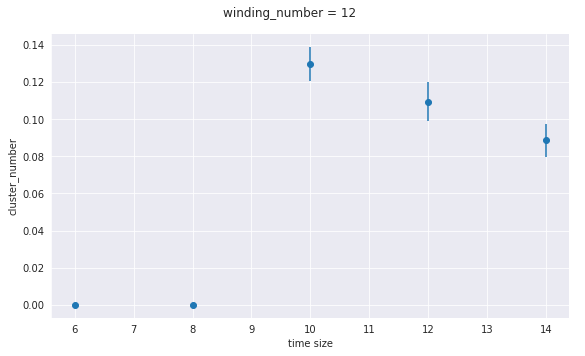

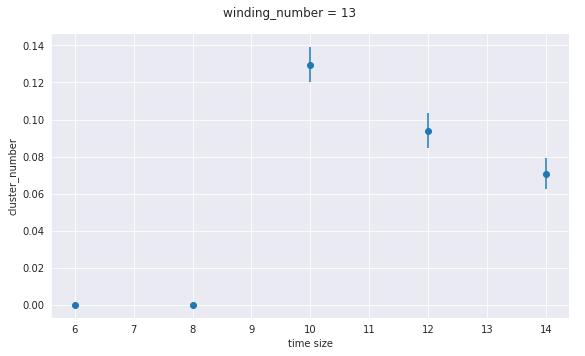

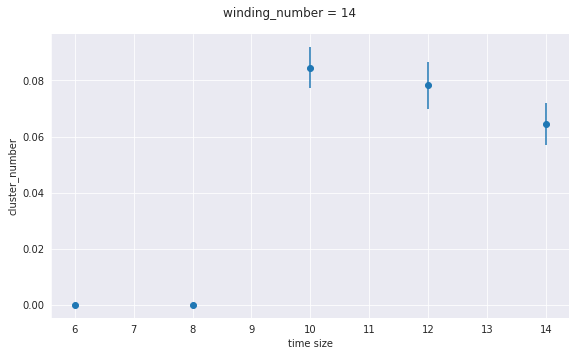

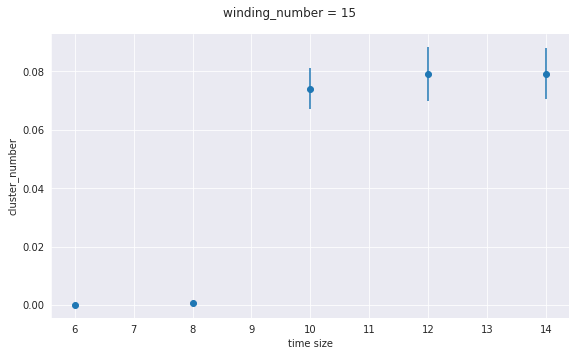

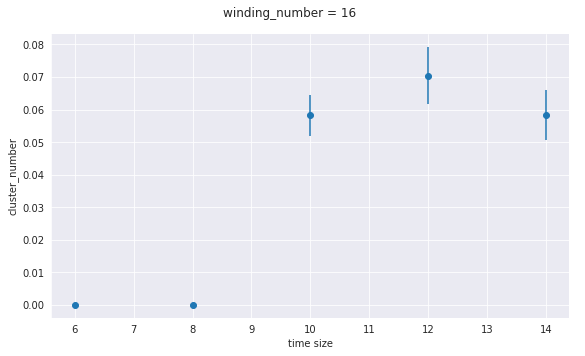

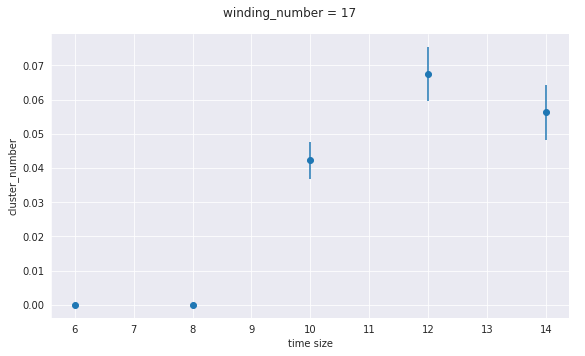

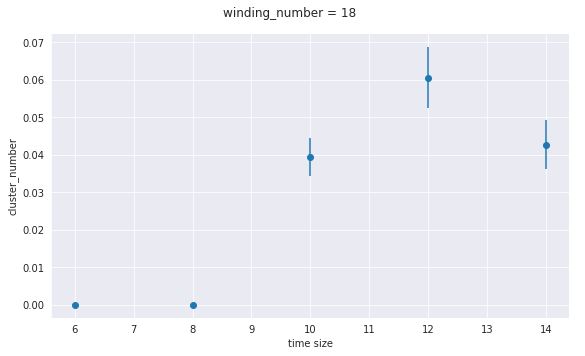

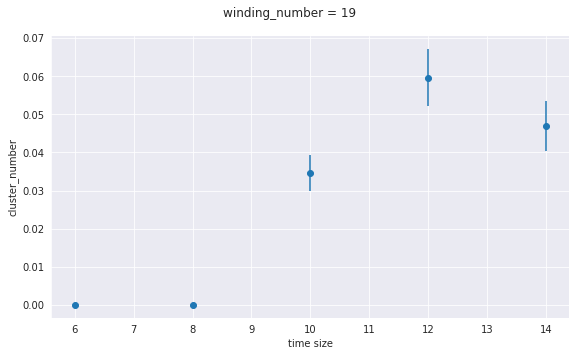

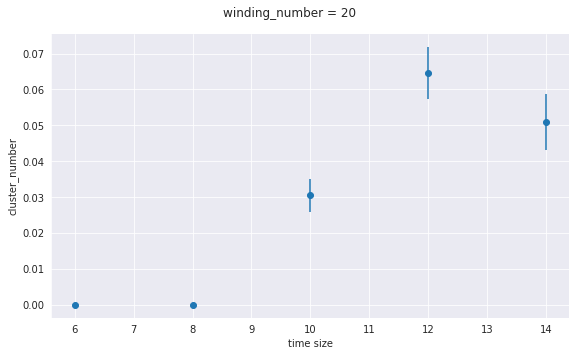

In [58]:
paths = [('../data/monopoles_su3/nt6/steps_330/copies=1', 6), ('../data/monopoles_su3/nt8/steps_330/copies=1', 8), \
        ('../data/monopoles_su3/nt10/steps_330/copies=1', 10), ('../data/monopoles_su3/nt12/steps_330/copies=1', 12), \
        ('../data/monopoles_su3/nt14/steps_330/copies=1', 14)]

wrappings_time_dependence(501, 1200, paths)

In [9]:
paths = [('../../data/nt4/steps_2000/copies=1', 4), ('../../data/nt6/steps_330/copies=1', 6), ('../../data/nt8/steps_330/copies=1', 8), \
        ('../../data/nt10/steps_330/copies=1', 10), ('../../data/nt12/steps_330/copies=1', 12), \
        ('../../data/nt14/steps_330/copies=1', 14)]

wrappings_number_dependence(501, 1200, paths)

ValueError: No objects to concatenate

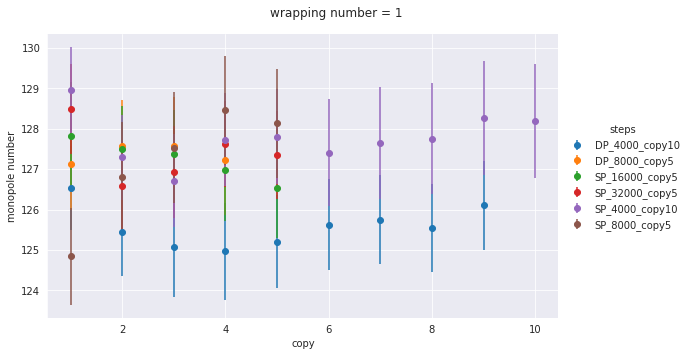

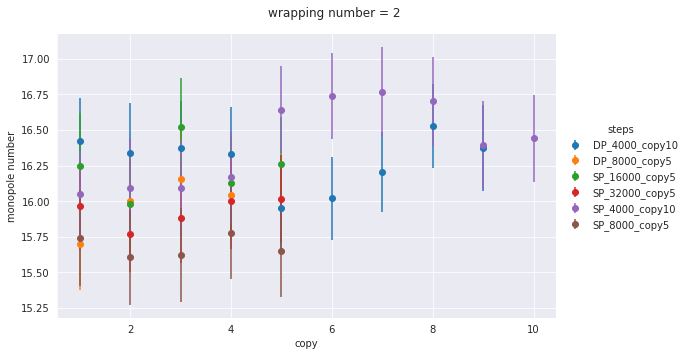

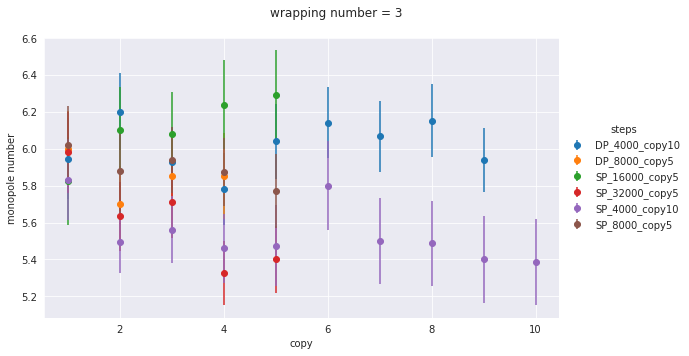

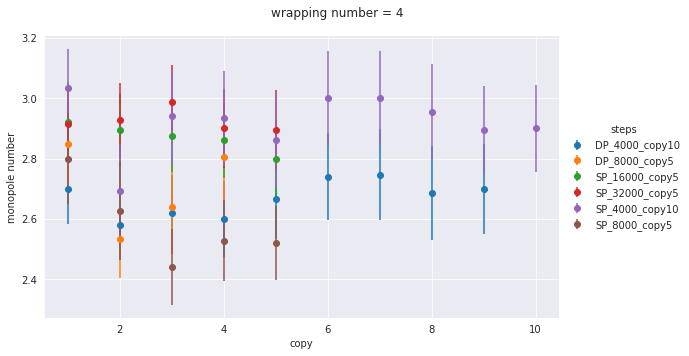

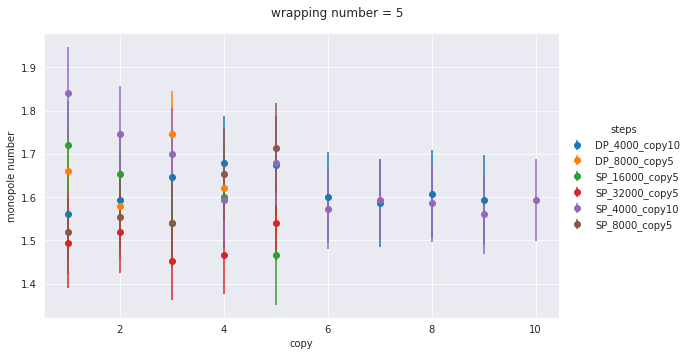

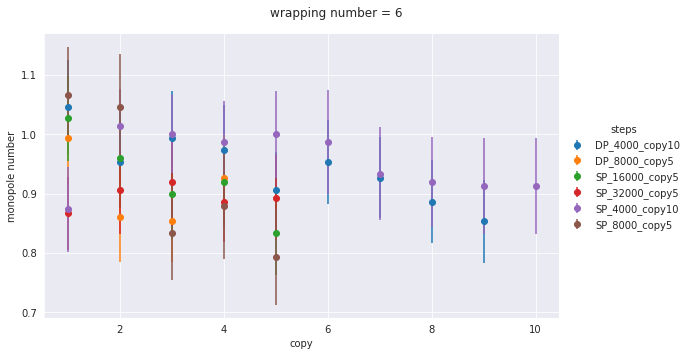

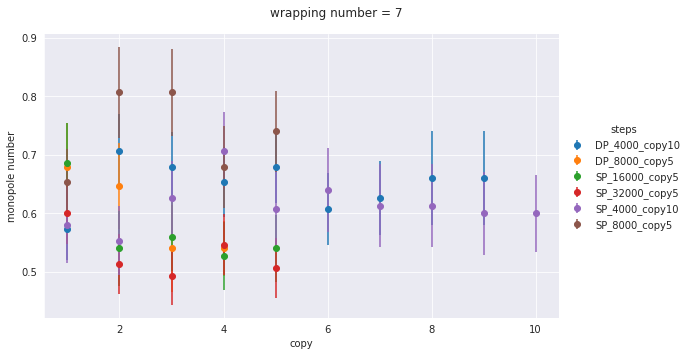

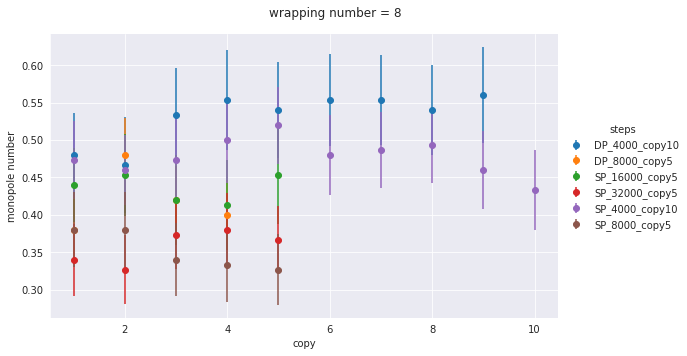

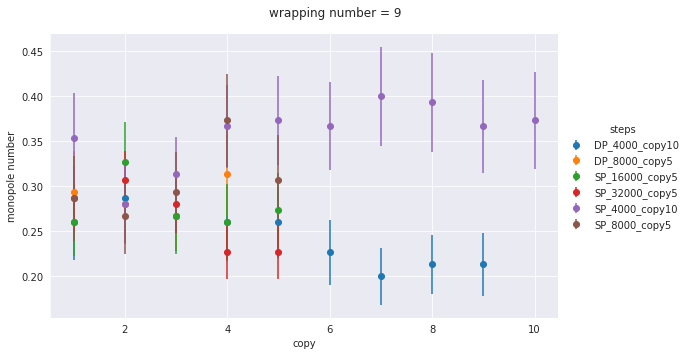

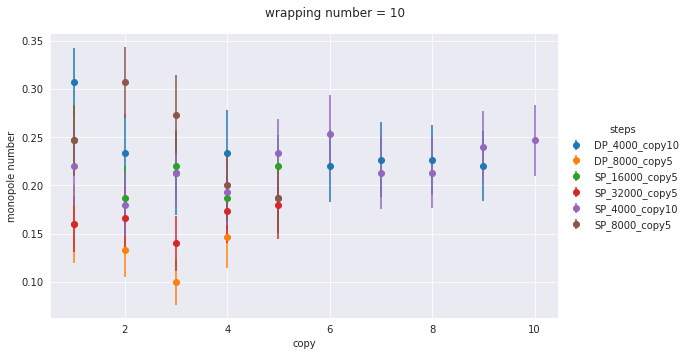

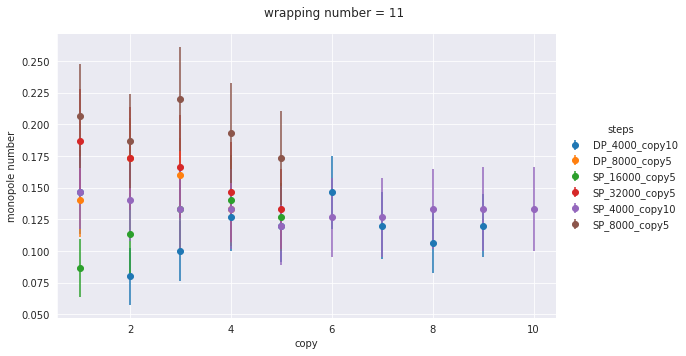

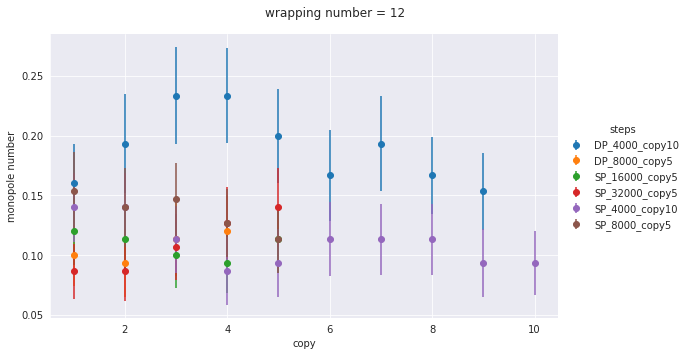

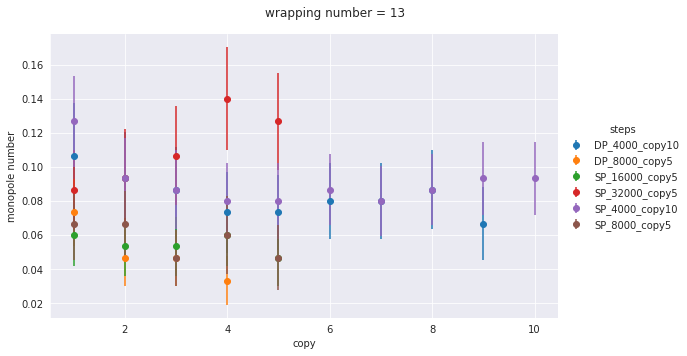

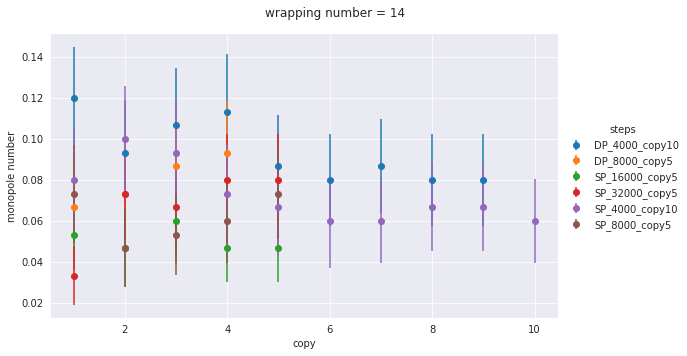

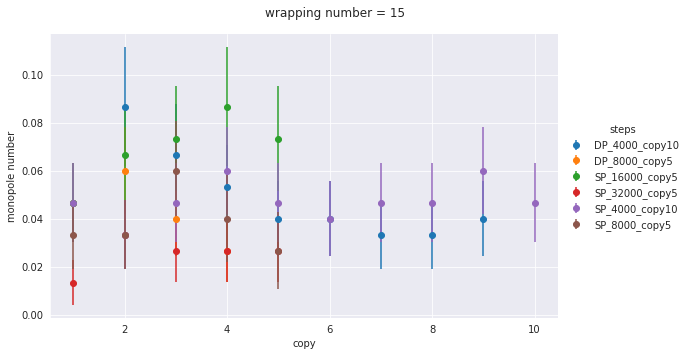

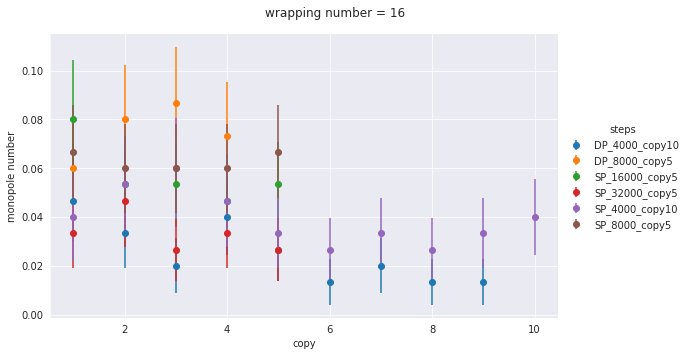

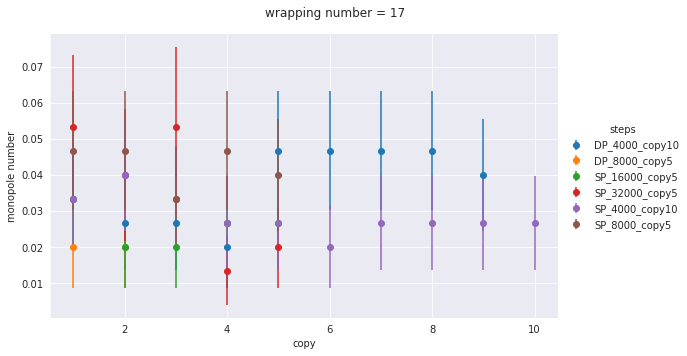

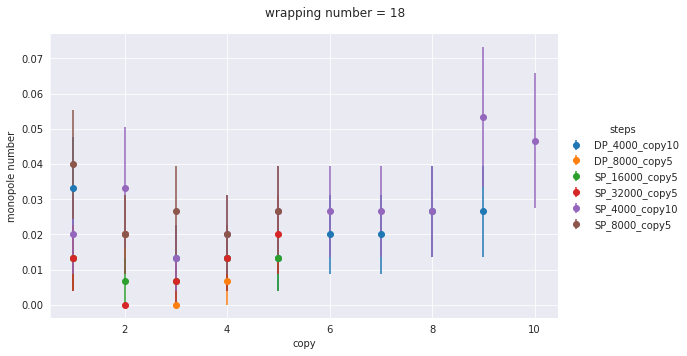

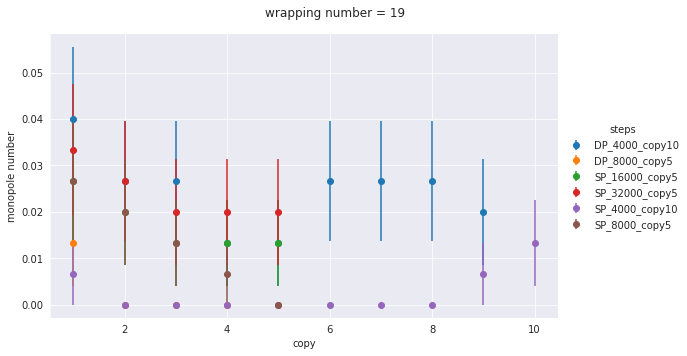

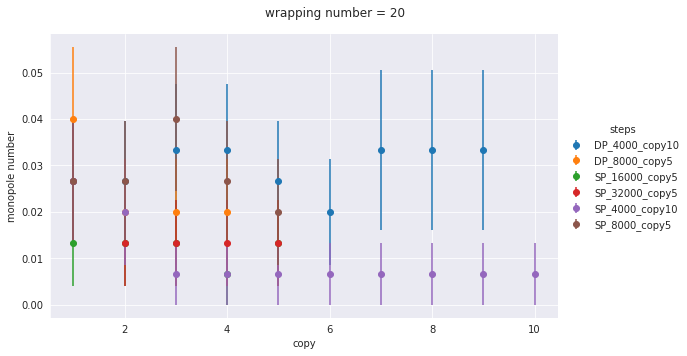

In [ ]:
paths = [('../../data/nt10/test/steps_4000/copies=10', 'SP_4000_copy10', 10), \
            ('../../data/nt10/test/steps_8000/copies=5', 'SP_8000_copy5', 5), \
            ('../../data/nt10/test/steps_16000/copies=5', 'SP_16000_copy5', 5), \
            ('../../data/nt10/test/steps_32000/copies=5', 'SP_32000_copy5', 5), \
            ('../../data/nt10/test/double/steps_4000/copies=10', 'DP_4000_copy10', 10), \
            ('../../data/nt10/test/double/steps_8000/copies=5', 'DP_8000_copy5', 5)]

wrappings_time_copies(501, 1200, paths)

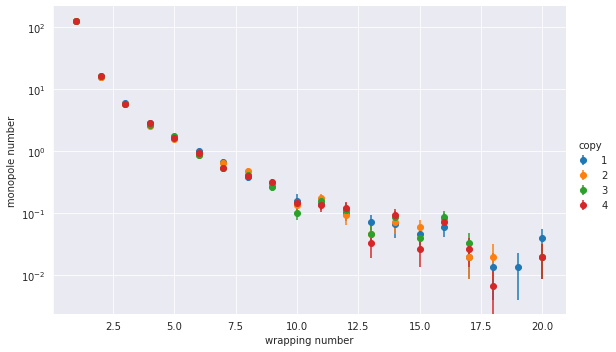

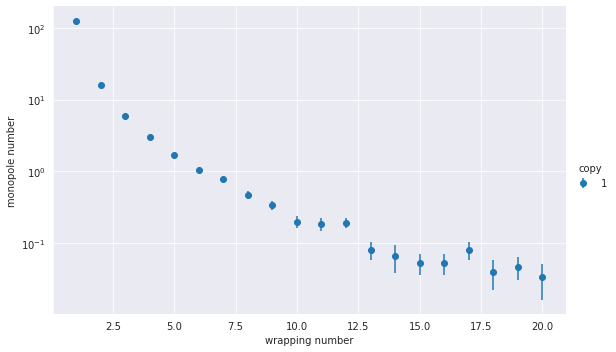

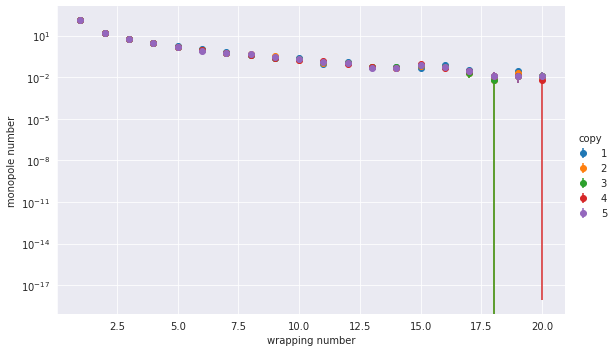

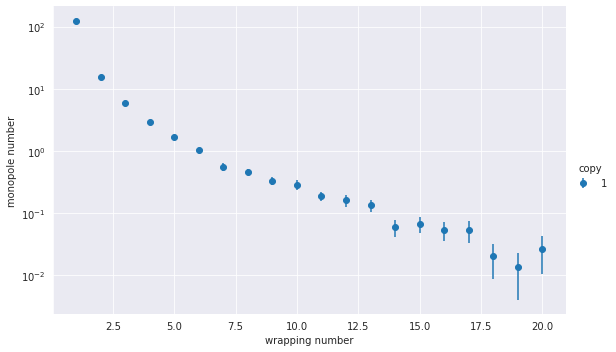

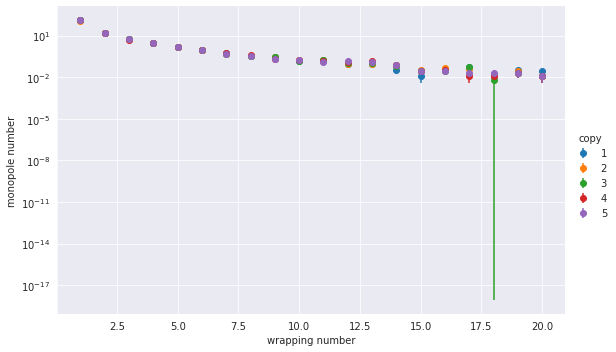

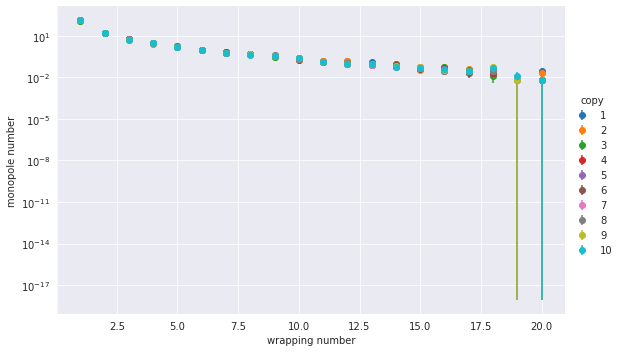

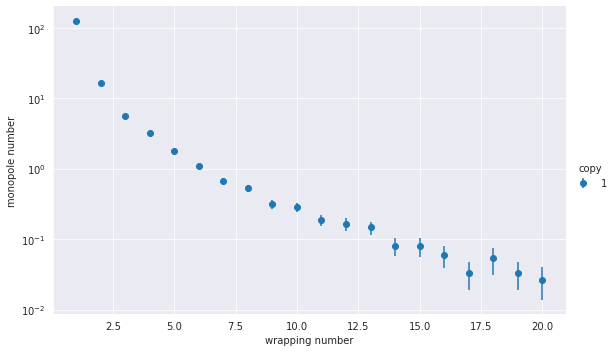

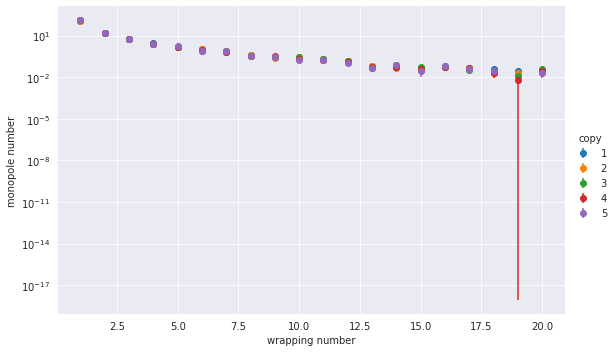

In [ ]:
paths = [('../../data/nt10/steps_2000', 'SP_2000_copy1', 1), \
         ('../../data/nt10/steps_1000', 'SP_1000_copy1', 1), \
         ('../../data/nt10/steps_500', 'SP_500_copy1', 1),\
        ('../../data/nt10/test/steps_4000/copies=10', 'SP_4000_copy10', 10), \
         ('../../data/nt10/test/steps_8000/copies=5', 'SP_8000_copy5', 5),\
        ('../../data/nt10/test/double/steps_8000/copies=5', 'DP_8000_copy5', 5), \
         ('../../data/nt10/test/steps_16000/copies=5', 'SP_16000_copy5', 5), \
        ('../../data/nt10/test/steps_32000/copies=5', 'SP_32000_copy5', 5)]
wrappings_number_copies(501, 1200, paths)

In [10]:
# functions for density of wrapped and unwrapped clusters

def data_process_density(data):
    return data.groupby(['cluster size', 'time size', 'conf'])['number']\
        .agg([('number', np.sum)]).reset_index()\
        .groupby(['cluster size', 'time size'])['number']\
        .agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index()

def density_lower(start, end, paths, ranges, wrapp):
    
    data = read_data(start, end, paths, wrapp, read_density_lower)
    
    data['number'] = data['number'] / data['time size']
    
    data = data_process_density(data)
    
    for r in ranges:
                
        df = data[data['cluster size'] <= r[1]]
        df = df[df['cluster size'] >= r[0]]
    
    
#     data['number']  = data['number'] * data['cluster size'] * data['cluster size']
    
#     df['number'] = df['number'] * df['cluster size']
    
        fg = seaborn.FacetGrid(data=df, hue = 'time size', height=5, aspect=1.61)
        fg.fig.suptitle(f'cluster density')
        plt.yscale('log')
        fg.map(plt.errorbar, 'cluster size', 'number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    
        image_path = f'../../images/common'
        try:
            os.makedirs(image_path)
        except:
            pass
    
        image_path = f'{image_path}/monopole_density_{wrapp}_{r[0]}_{r[1]}'
        fg.savefig(image_path, dpi=400)
        
    data.to_csv(f'../../data/{wrapp}_common', sep = ' ', index=False)
    
def density_lower_time_dependence(start, end, paths, cluster_sizes, wrapp):
    
    data = read_data(start, end, paths, wrapp, read_density_lower)
    
    data['number'] = data['number'] / data['time size']
    
    data = data_process_density(data)
    
    for size in cluster_sizes:
                
        df = data[data['cluster size'] == size]
    
#     data['number']  = data['number'] * data['cluster size'] * data['cluster size']
    
#     df['number'] = df['number'] * df['cluster size']
    
        fg = seaborn.FacetGrid(data=df, height=5, aspect=1.61)
#         fg.fig.suptitle(f'cluster size = {size}')
#         plt.yscale('log')
        fg.map(plt.errorbar, 'time size', 'number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    
        image_path = f'../../images/common'
        try:
            os.makedirs(image_path)
        except:
            pass
    
        image_path = f'{image_path}/monopole_density_time_{wrapp}_size={size}'
        fg.savefig(image_path, dpi=400)

def fill_unwrapped_upper(data):
    return data.set_index(['conf','color', 'cluster size']).unstack('cluster size', fill_value=0).stack()

def make_bins(data):
    print(data)
    bin_size = (data.name.left + data.name.right) / 2
    return data.sum()/bin_size

def data_process_upper(data, bin_num):
    return data.groupby([pd.cut(data['cluster size'], bin_num)])['number']\
        .apply(make_bins).reset_index()\
        .groupby(['cluster size'])['number']\
        .agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))])

def density_upper(start, end, paths, bin_num, wrapp):
    data = read_data(start, end, paths, wrapp, read_density_upper)

    data = data.groupby(['time size'])[['color', 'cluster size', 'number', 'conf']].apply(fill_unwrapped_upper).reset_index()

    # print(data)

    data = data.groupby(['cluster size', 'time size', 'conf'])['number']\
        .agg([('number', np.mean)]).reset_index()\
        .groupby(['time size'])\
        .apply(data_process_upper, bin_num).reset_index()

    data['cluster size'] = data['cluster size'].apply(lambda x: (x.right + x.left) / 2)

    fg = seaborn.FacetGrid(data=data, hue = 'time size', height=5, aspect=1.61)
    fg.fig.suptitle(f'cluster density')
    plt.yscale('log')
    fg.map(plt.errorbar, 'cluster size', 'number', 'std', marker="o", fmt='', linestyle = '').add_legend()

    # print(data)

def maximal_cluster(start, end, paths):
    data = []
    data.append(read_data(start, end, paths, 'unwrapped', read_density_upper))
    data.append(read_data(start, end, paths, 'wrapped', read_density_upper))

    data = pd.concat(data)
    
def statistics_unwrapped_upper(start, end, paths, copies, bin_num, max_length):
    data = read_data_history(start, end, paths, copies, 'unwrapped', read_unwrapped_upper)
    
    data = data[data['cluster size'] <= max_length]

    data = data.groupby(['copy', 'steps'])[['color', 'cluster size', 'number' , 'num']].apply(fill_unwrapped_upper).reset_index()

    data = data.groupby(['cluster size', 'steps', 'copy', 'num'])['number']\
        .agg([('number', np.sum)]).reset_index()
    data = data.groupby([pd.cut(data['cluster size'], bin_num), 'steps', 'copy', 'num'])['number']\
        .apply(make_bins).reset_index()\
    .groupby(['cluster size', 'steps', 'copy'])['number']\
        .agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index()
    
    data['cluster size'] = data['cluster size'].apply(lambda x: (x.right + x.left) / 2)
    
    return data
    
def plot_data_unwrapped_history_upper(start, end, paths, copies, bin_num, max_length):
    
    data = read_data_history(start, end, paths, copies, 'unwrapped', read_unwrapped_upper)
    
#     data['number']  = data['number'] * data['cluster size'] * data['cluster size']

#     data = data[data['copy'] <= 2]

    data = data[data['cluster size'] <= max_length]

    data = data.groupby(['copy', 'steps'])[['color', 'cluster size', 'number' , 'num']].apply(fill_unwrapped_upper).reset_index()

    df = data.groupby(['cluster size', 'steps', 'copy', 'num'])['number']\
        .agg([('number', np.sum)]).reset_index()
    df = df.groupby([pd.cut(df['cluster size'], bin_num), 'steps', 'copy', 'num'])['number']\
        .apply(make_bins).reset_index()\
    .groupby(['cluster size', 'steps', 'copy'])['number']\
        .agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index()
    
    #         .agg([('number', np.mean)])\
    
    df['cluster size'] = df['cluster size'].apply(lambda x: (x.right + x.left) / 2)
    
    
    fg = seaborn.FacetGrid(data=df, hue = 'copy', height=5, aspect=1.61)
    fg.fig.suptitle(f'cluster density')
    plt.yscale('log')
    fg.map(plt.errorbar, 'cluster size', 'number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    
    image_path = f'/home/ilya/soft/lattice/monopoles_su3/images'
    try:
        os.makedirs(image_path)
    except:
        pass
    
    image_path = f'{image_path}/monopole_density_muliplied'
    fg.savefig(image_path, dpi=400)
    
def plot_data_unwrapped_history_full(start, end, paths, copies, bin_num_upper, max_upper_length):
    data = []
    data.append(statistics_unwrapped_lower(start, end, paths, 0, 202, copies))
    data.append(statistics_unwrapped_upper(start, end, paths, copies, bin_num_upper, max_upper_length))
    
    data = pd.concat(data)
    
    fg = seaborn.FacetGrid(data=data, hue = 'copy', height=5, aspect=1.61)
    fg.fig.suptitle(f'cluster density')
    plt.yscale('log')
    fg.map(plt.errorbar, 'cluster size', 'number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    
def read_clusters(start, end, paths, name):
    data = []
    for path in paths1:
        for i in range(start, end + 1):
            data_path = f'{path[0]}/{name}_{i:04}'
            if(os.path.isfile(data_path)):
                data.append(read_unwrapped_lower(data_path))
                data[-1]['num'] = i
                data[-1]['steps'] = path[1]
                data[-1]['type'] = name
                
    return pd.concat(data)

def plot_clusters_all(start, end, paths):
    data = []
    data.append(read_clusters(start, end, paths, 'wrapped'))
    data.append(read_clusters(start, end, paths, 'unwrapped'))
    
    data = pd.concat(data)
    
    data = data.groupby(['cluster size', 'num', 'steps'])['number'].agg(np.sum).reset_index()
    
    data = data.groupby(['cluster size', 'steps'])['number']\
        .agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index()
    
    fg = seaborn.FacetGrid(data=data, hue = 'steps', height=5, aspect=1.61)
    plt.yscale('log')
    fg.map(plt.errorbar, 'cluster size', 'number', 'std', marker="o", fmt='', linestyle = '').add_legend()
    


In [12]:
paths = [('../data/monopoles_su3/QCD/140MeV/nt6/DP_steps_330/copies=1', 6), ('../data/monopoles_su3/QCD/140MeV/nt8/DP_steps_330/copies=1', 8), \
        ('../data/monopoles_su3/QCD/140MeV/nt10/DP_steps_330/copies=1', 10), ('../data/monopoles_su3/QCD/140MeV/nt12/DP_steps_330/copies=1', 12), \
        ('../data/monopoles_su3/QCD/140MeV/nt14/DP_steps_330/copies=1', 14)]

ranges = [(0, 25), (25, 75), (75, 202), (0, 202)]
# ranges = [(0, 202)]

density_lower(501, 1200, paths, ranges, 'unwrapped')

ValueError: No objects to concatenate

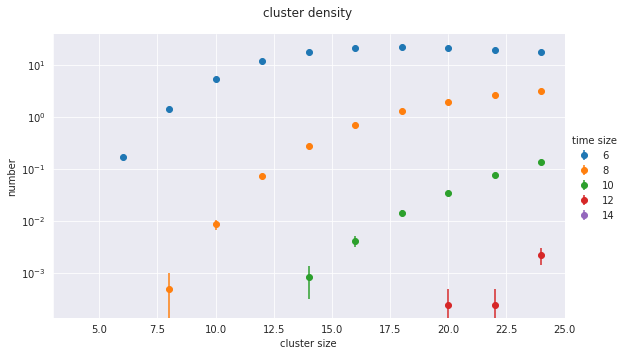

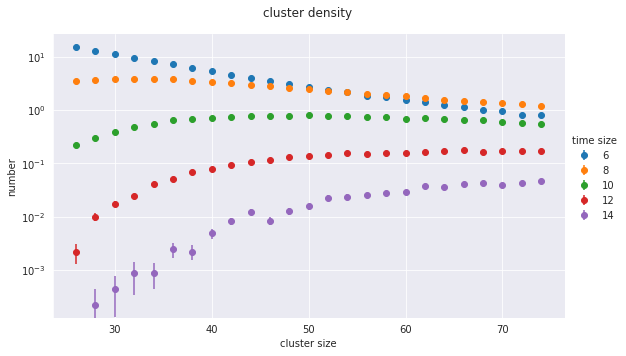

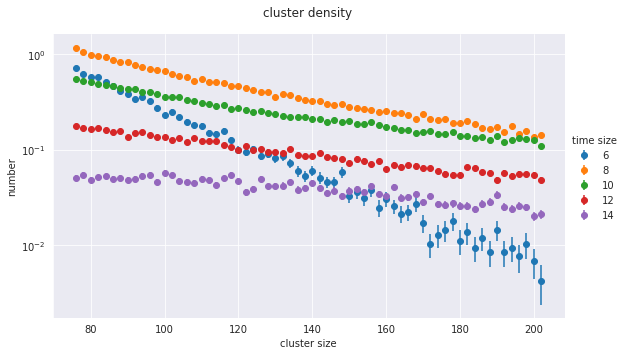

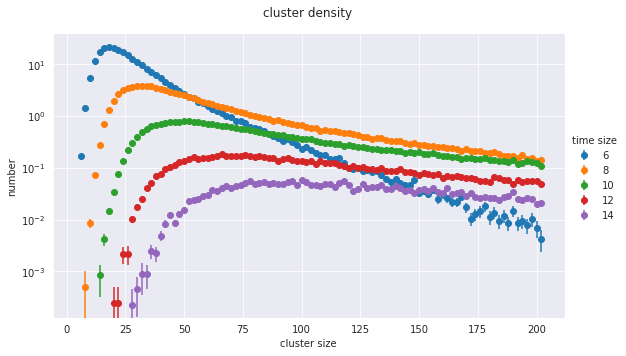

In [7]:
paths = [('../../data/nt6/steps_330/copies=1', 6), ('../../data/nt8/steps_330/copies=1', 8), \
        ('../../data/nt10/steps_330/copies=1', 10), ('../../data/nt12/steps_330/copies=1', 12), \
        ('../../data/nt14/steps_330/copies=1', 14)]

ranges = [(0, 25), (25, 75), (75, 202), (0, 202)]
# ranges = [(0, 202)]

density_lower(501, 1200, paths, ranges, 'wrapped')

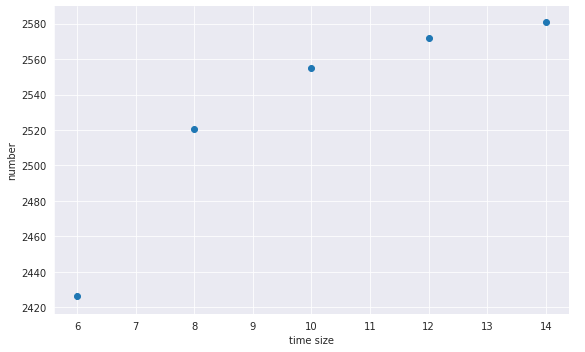

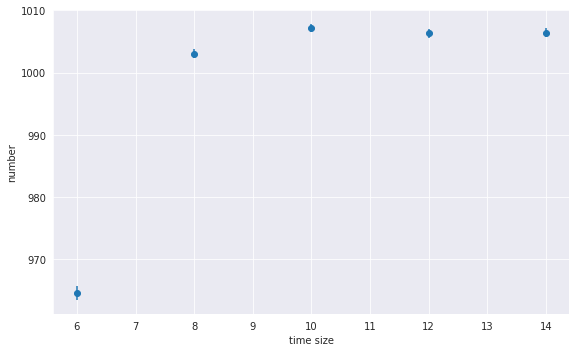

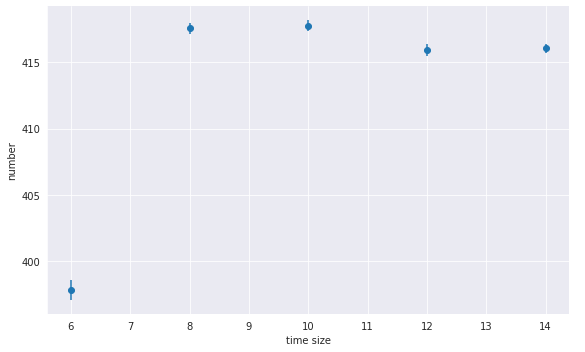

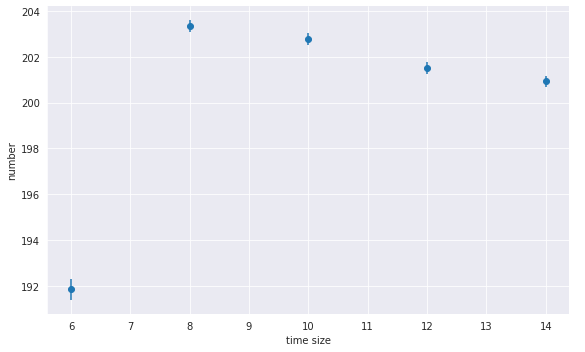

In [9]:
paths = [('../../data/nt6/steps_330/copies=1', 6), ('../../data/nt8/steps_330/copies=1', 8), \
        ('../../data/nt10/steps_330/copies=1', 10), ('../../data/nt12/steps_330/copies=1', 12), \
        ('../../data/nt14/steps_330/copies=1', 14)]

cluster_sizes = [4, 6, 8, 10]

density_lower_time_dependence(501, 1200, paths, cluster_sizes, 'unwrapped')

1640    1.0
1641    0.0
1642    0.0
1643    0.0
1644    0.0
1645    0.0
1646    0.0
1647    0.0
3288    0.0
3289    0.0
3290    1.0
3291    0.0
3292    0.0
3293    0.0
3294    1.0
3295    0.0
Name: (205.95, 211.0], dtype: float64
6576    0.0
6577    0.0
6578    0.0
6579    1.0
6580    0.0
6581    1.0
6582    0.0
6583    0.0
Name: (211.0, 216.0], dtype: float64
13144    0.0
13145    0.0
13146    0.0
13147    0.0
13148    0.0
13149    0.0
13150    0.0
13151    1.0
Name: (216.0, 221.0], dtype: float64
18072    0.0
18073    0.0
18074    0.0
18075    0.0
18076    1.0
18077    0.0
18078    0.0
18079    0.0
Name: (221.0, 226.0], dtype: float64
Series([], Name: (226.0, 231.0], dtype: float64)
Series([], Name: (231.0, 236.0], dtype: float64)
Series([], Name: (236.0, 241.0], dtype: float64)
Series([], Name: (241.0, 246.0], dtype: float64)
Series([], Name: (246.0, 251.0], dtype: float64)
42680    0.0
42681    1.0
42682    0.0
42683    0.0
42684    0.0
42685    0.0
42686    0.0
42687    0.0
Name: 

/home/ilya/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ilya/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ilya/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ilya/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ilya/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


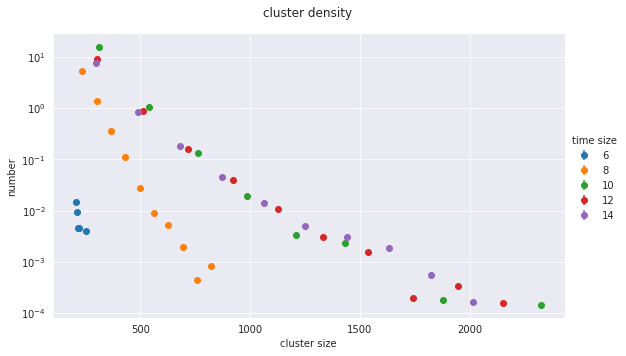

In [10]:
paths = [('../../data/nt6/steps_330/copies=1', 6), ('../../data/nt8/steps_330/copies=1', 8), \
        ('../../data/nt10/steps_330/copies=1', 10), ('../../data/nt12/steps_330/copies=1', 12), \
        ('../../data/nt14/steps_330/copies=1', 14)]

# paths = [('../../data/nt6/steps_330/copies=1', 6)]

ranges = [(0, 25), (25, 75), (75, 202), (0, 202)]

density_upper(501, 1200, paths, 10, 'unwrapped')

     nt      N_max  N_max err     N_tot  N_tot err     ratio  ratio err
0   6.0    128.667      1.991   54399.7      50.33  0.002365   0.000037
1   8.0    438.468     12.090   81534.2     104.00  0.005378   0.000148
2  10.0   2563.080     99.020  112293.0      96.24  0.022825   0.000882
3  12.0  19898.500    582.600  142390.0     134.80  0.139746   0.004094
4  14.0  38158.700    913.700  171480.0     117.00  0.222526   0.005330


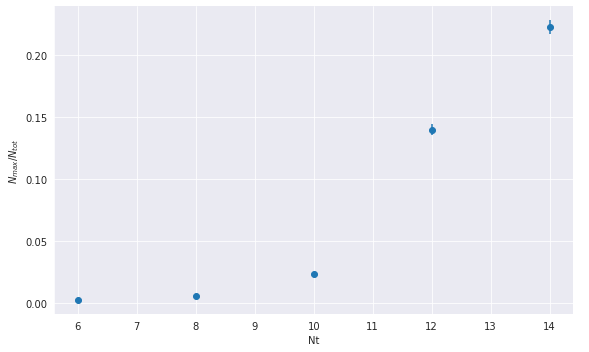

In [11]:
# 6  128.667     1.991 54399.7    50.33 
#   8  438.468     12.09  81534.2   104
#   10 2563.08     99.02  112293     96.24 
#   12 19898.5     582.6   142390     134.8
#   14 38158.7     913.7  171480       117

x = np.array([[6, 8, 10, 12, 14], [128.667, 438.468, 2563.08, 19898.5, 38158.7], [1.991, 12.09, 99.02, 582.6, 913.7],
        [54399.7, 81534.2, 112293, 142390, 171480], [50.33, 104, 96.24, 134.8, 117]])

data = pd.DataFrame(np.transpose(x),
        columns=['nt', 'N_max', 'N_max err', 'N_tot', 'N_tot err'])

data['ratio'] = data['N_max'] / data['N_tot']
data['ratio err'] = data.apply(lambda x: math.sqrt(x['N_max err'] ** 2 / x['N_tot'] ** 2 + x['N_tot err'] ** 2 * x['N_max'] ** 2 / x['N_tot'] ** 4), axis=1)

print(data)



fg = seaborn.FacetGrid(data=data, height=5, aspect=1.61)
# plt.yscale('log')
fg.map(plt.errorbar, 'nt', 'ratio', 'ratio err', marker="o", fmt='', linestyle = '').add_legend()
fg.ax.set_ylabel(r"$N_{max}/N_{tot}$", fontsize=10)
fg.ax.set_xlabel(r"Nt", fontsize=10)

fg.savefig('../images/monopoles_su3/QCD/140MeV/max_cluster/ratio', dpi=400)